# Dataset Description
The data is related with telephonic marketing campaigns of a Portuguese banking institution. The classification goal is to predict whether the client will subscribe a term deposit (variable y).

Source: <a href="https://www.kaggle.com/prakharrathi25/banking-dataset-marketing-targets?select=test.csv">Bank Marketing Data Set</a>

| Columns | Description | Type | Remarks |
| :- | :- | :- | :- |
| age | numeric | bank client data | |
| job | type of job | bank client data | |
| marital | marital status | bank client data | |
| education | education tier | bank client data | |
| default | has credit in default? | bank client data | |
| balance | average yearly balance, in euros | bank client data | |
| housing | has housing loan? | bank client data | |
| loan | has personal loan? | bank client data | |
| contact | contact communication type | related with last contact of the current campaign | |
| day | last contact day of the month | related with last contact of the current campaign | |
| month | last contact month of year | related with last contact of the current campaign | |
| duration | last contact duration, in seconds | related with last contact of the current campaign | |
| campaign | number of contacts performed during this campaign and for this client | others | |
| previous | number of contacts performed before this campaign and for this client | others | | 
| pdays | number of days that passed by after the client was last contacted from a previous campaign | others | pdays = -1 means client was not previously contacted (previous = 0) | |
| poutcome | outcome of the previous marketing campaign | others | |
| y | has the target subscribed a term deposit? | target variable | |

# Import Package

In [1]:
!pip install catboost

In [2]:
# Import library
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn import under_sampling, over_sampling

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

# Dataset

In [3]:
df = pd.read_csv('train.csv', sep=';')
df.sample(8)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
41928,64,management,married,tertiary,no,4688,no,no,cellular,21,oct,200,1,-1,0,unknown,yes
12463,45,technician,married,tertiary,no,-302,no,yes,unknown,1,jul,80,1,-1,0,unknown,no
15635,30,blue-collar,married,secondary,no,658,yes,yes,cellular,21,jul,212,1,-1,0,unknown,no
31890,29,blue-collar,single,secondary,no,314,yes,no,cellular,9,apr,161,1,316,2,other,no
1152,35,management,divorced,tertiary,no,788,yes,no,unknown,7,may,297,3,-1,0,unknown,no
37306,45,blue-collar,divorced,primary,no,-69,yes,no,cellular,13,may,118,2,-1,0,unknown,no
24515,26,unknown,single,secondary,no,1187,no,no,unknown,17,nov,44,1,-1,0,unknown,no
16356,28,technician,single,tertiary,no,-123,no,yes,cellular,23,jul,690,1,-1,0,unknown,yes


# Exploratory Data Analysis (EDA)

## Descriptive Statistics

In [ ]:
# Melihat info dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [ ]:
# Cek data duplikat
df.duplicated().any()

False

In [ ]:
# Cek data null
df.isnull().any()

age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

Pengamatan:
1. Dataset terdiri dari 17 kolom dan 45211 baris
2. Terdapat 7 data numerikal dan 10 data kategorikal
3. Dari hasil pengecekan, tidak ada issue yang mencolok pada tipe data untuk setiap kolom (tipe data sudah sesuai)
4. Tidak terdapat missing values, tetapi terdapat unknown values pada beberapa feature
5. Dataset tidak memiliki data yang duplikat
6. Terdapat beberapa fitur yang bertipe categorical sehingga harus dilakukan label encoding / one-hot encoding / feature hashing
7. Kolom yang akan menjadi feature target adalah kolom `y`

**Saran**: Tidak mengubah *unknown values* yang terdapat pada beberapa feature karena jika diubah takut akan terjadi bias


In [ ]:
# Split kolom numerikal dan kolom kategorikal
num_cols = df.select_dtypes('number').columns.tolist()
cat_cols = df.select_dtypes('object').columns.tolist()
print(num_cols)
print(cat_cols)

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


In [ ]:
# Melihat deskripsi kolom numerikal
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


In [ ]:
# Melihat hubungan kolom previous dan pdays
df[(df['previous'] == 0) & (df['pdays'] == -1)].shape[0]

36954

In [ ]:
# Melihat hubungan kolom previous dan pdays
df[(df['previous'] != 0) & (df['pdays'] == -1)].shape[0]

0

In [ ]:
# Melihat hubungan kolom previous dan pdays
df[(df['previous'] == 0) & (df['pdays'] != -1)].shape[0]

0

In [ ]:
# Melihat kolom balance negatif
df[df['balance'] < 0].shape[0]

3766

In [ ]:
# Melihat jumlah data dengan balance negatif dan y yes
df[(df.y == 'yes') & (df.balance < 0)].shape[0]

210

In [ ]:
# Melihat data previous
df[(df.previous > 30)]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
26668,51,entrepreneur,married,secondary,no,653,yes,no,cellular,20,nov,16,9,112,37,other,no
28498,49,management,single,tertiary,no,145,yes,no,cellular,29,jan,57,2,248,38,failure,no
28886,31,management,single,tertiary,no,358,yes,no,cellular,30,jan,68,3,256,51,failure,no
29182,40,management,married,tertiary,no,543,yes,no,cellular,2,feb,349,2,262,275,other,no
37567,39,management,married,tertiary,no,0,yes,no,cellular,14,may,11,15,261,38,failure,no
38326,46,blue-collar,married,primary,no,1085,yes,yes,cellular,15,may,523,2,353,58,other,yes
39141,44,admin.,married,secondary,no,429,yes,yes,cellular,18,may,35,3,349,32,failure,no
42422,27,student,single,secondary,no,91,no,no,telephone,4,dec,157,6,95,37,other,no
42611,35,technician,single,secondary,no,4645,yes,no,cellular,11,jan,502,3,270,40,other,no
44089,37,technician,married,secondary,no,432,yes,no,cellular,6,jul,386,3,776,55,failure,yes


Dari hasil inspeksi di atas, beberapa insight yang dapat diambil adalah:
- Kolom `age` sepertinya berdistribusi normal karena memiliki nilai mean dan median yang berdekatan
- Kolom lain memiliki mean yang cukup jauh dari median, yang berarti distribusinya tidak mendekati normal
- Kolom `pdays` menunjukkan jumlah hari yang yang telah berlalu setelah customer dihubungi pada campaign sebelumnya. 
- Kolom `balance` memiliki nilai negatif sebanyak 3766, tetapi nilainya masih masuk akal
- Kolom `previous` (jumlah kontak yang dilakukan pada campaign sebelumnya) memiliki nilai maksimum yang sangat tinggi, yaitu 275 (indikasi sebagai outlier)
- Data dengan `pdays` = -1 pasti nilai `previous` = 0, dan data ini tampak mendominasi
- Perlu dilakukan rescaling pada masing-masing kolom

In [ ]:
# Melihat deskripsi kolo kategorikal
df[cat_cols].describe()

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


In [ ]:
# Melihat detail jumlah masing-masing kolom
for col in cat_cols:
    print(f'Value count kolom {col}:')
    print(df[col].value_counts())
    print()

Value count kolom job:
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

Value count kolom marital:
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

Value count kolom education:
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

Value count kolom default:
no     44396
yes      815
Name: default, dtype: int64

Value count kolom housing:
yes    25130
no     20081
Name: housing, dtype: int64

Value count kolom loan:
no     37967
yes     7244
Name: loan, dtype: int64

Value count kolom contact:
cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

Value count kolom month:
may    13766
jul     6895
aug     6247
jun     5341
nov     3970

In [ ]:
# Menghitung CVR
count_yes = df[df.y == 'yes'].shape[0]
count_all = df.shape[0]

CVR = round(count_yes / count_all * 100, 2)
CVR

11.7

Beberapa insight yang bisa diambil:
- Terdapat data unknown yang cukup banyak, terutama pada kolom `job`, `education`, `contact`, dan `poutcome`
- Tampak frekuensi yang imbalance dari kolom `marital`, `education`, `default`, `loan`, `contact`, `poutcome`, dan `y`
- 98% customers tidak gagal bayar (`default`)
- Lebih dari 80% customers tidak melakukan subsribe ke term deposit (`y`)
- Lebih dari 80% customers tidak memiliki utang (`loan`)
- Kolom `marital` didominasi (proporsi lebih dari 50%) oleh customers dengan status married
- Tipe kolom `default`, `housing`, `loan`, `y` dapat diubah menjadi boolean/binary
- Nilai CVR sebesar 11.7%


[QUESTION]

1. Apakah ada kolom dengan tipe data kurang sesuai?
    
    *Tidak ada. Semua kolom sudah memiliki tipe data yang sesuai.*

2. Apakah ada kolom yang memiliki nilai kosong (missing values)? Jika ada, apa saja?

  *Tidak ada kolom yang memiliki nilai kosong. Ada beberapa kolom yang memiliki 'unknown' values, yaitu kolom `job`, `education`, `contact`, dan `poutcome`. Kami memilih untuk tidak mengubahnya untuk menghindari adanya bias pada data apabila unknown value-nya diubah menjadi value lain.*

3. Apakah ada kolom yang isi nilainya tidak sesuai?

  *Kolom `balance` dan `pdays` memiliki nilai negatif. Untuk nilai `balance` yang negatif, sepertinya tidak ada masalah. Kami mengasumsikan customer memiliki hutang pada tabungannya. Nilai `pdays` (previous day) = -1 menunjukkan bahwa customer tidak dihubungi pada campaign sebelumnya. Ada kemungkinan kami mengubah nilainya menjadi 999 yang mewakili durasi hari yang sangat lama.*

4. Apakah ada kolom yang memiliki nilai summary agak aneh?

  *Beberapa kolom memiliki mean yang cukup jauh dari median, yang berarti distribusinya tidak mendekati normal. Kolom-kolom ini adalah `age`, `balance`, `campaign`, `duration`, `pdays`, dan `previous`. Kolom `balance`, `duration`, `pdays`, `previous` juga memiliki nilai maksimal yang jauh dari median.*

## Univariate Analysis

### Numerical

Boxplot

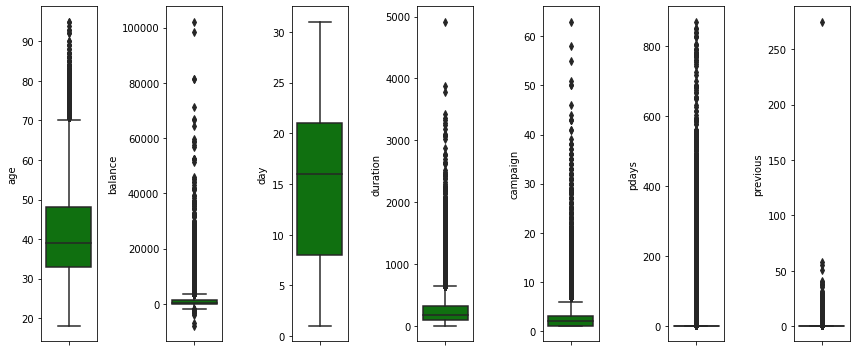

In [ ]:
plt.figure(figsize=(12, 5))
for i in range(len(num_cols)):
    plt.subplot(1,7,i+1)
    sns.boxplot(y = df[num_cols[i]], color='green', orient='v')
    plt.tight_layout()

Violin Plot

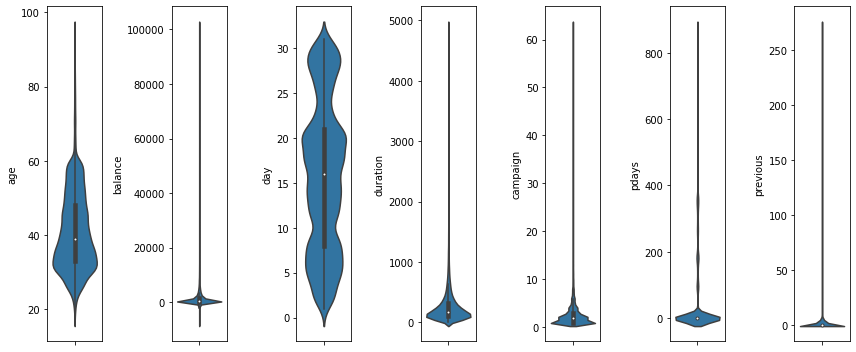

In [ ]:
plt.figure(figsize = (12,5))
for i in range(len(num_cols)):
    plt.subplot(1, 7, i+1)
    sns.violinplot(y = df[num_cols[i]])
    plt.tight_layout()

Dist Plot

- **Highly Skewed**: jika `skewness < -1` atau `skewness > 1`

- **Moderately Skewed**: jika `-1 < skewness < -0.5` atau `0.5 < skewness < 1` 

- **Normal/Mendekati Normal**: jika `-0.5 < skewness < 0.5`

In [ ]:
# Melihat nilai skew kolom numerikal
df_skew = df[num_cols].skew()
df_skew

age          0.684818
balance      8.360308
day          0.093079
duration     3.144318
campaign     4.898650
pdays        2.615715
previous    41.846454
dtype: float64

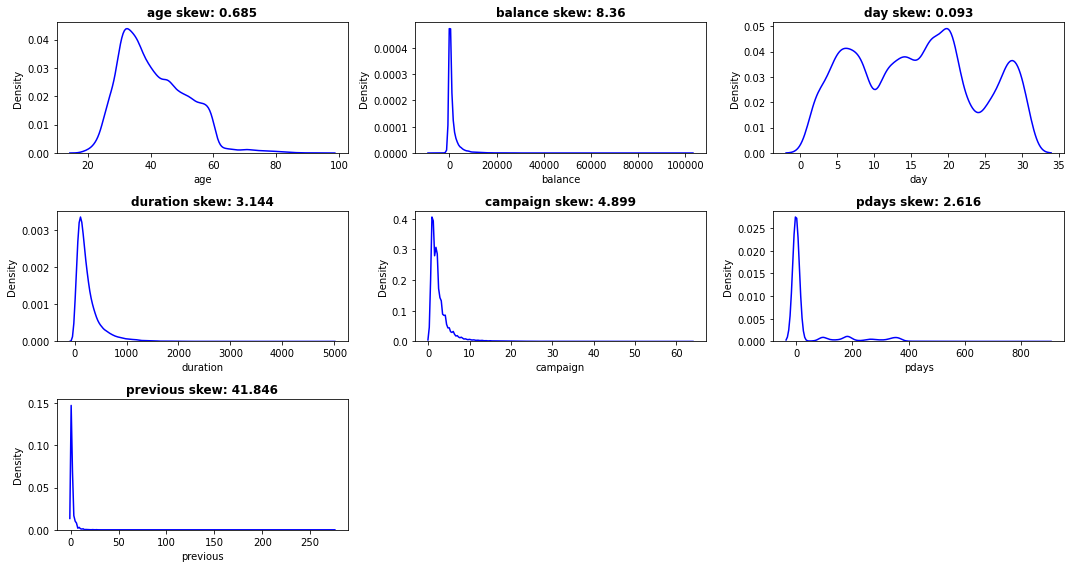

In [ ]:
features = num_cols
plt.figure(figsize=(15, 8))

for i in range(0, len(features)):
    plt.subplot(3, len(features)/2, i+1)
    sns.kdeplot(x=df[features[i]], color='blue')
    plt.xlabel(features[i])
    plt.title(features[i] + ' skew: ' + str(round(df_skew[features[i]], 3)), fontsize = 12, fontweight = 'bold')
    plt.tight_layout()

HASIL OBSERVASI

Beberapa insight yang bisa diambil:
- Semua kolom memiliki outlier, tetapi outlier utamanya terlihat pada kolom `balance`, `duration`, `campaign`, dan `previous`
- Tampak semua kolom memiliki distribusi yang skewed, kecuali kolom `day`
- Kolom `day` yang merupakan kolom tanggal, sehingga tidak perlu terlalu diperhatikan bentuk distribusinya

**To do:**
- Outliers handling
- Melakukan transformasi untuk kolom yang sangat-sangat skewed


### Categorical

In [ ]:
def show_val(ax):
    for b in ax.patches:
        x = b.get_x() + (b.get_width() / 2)
        y = b.get_y() + b.get_height() + (b.get_height() * 0.01)
        val = b.get_height()
        ax.text(x, y, val, ha = 'center')
        
def show_val_percent(ax):
    for b in ax.patches:
        x = b.get_x() + (b.get_width() / 2)
        y = b.get_y() + b.get_height() + (b.get_height() * 0.01)
        val = f'{b.get_height():.2f}%'
        ax.text(x, y, val, ha = 'center')
        
def show_val_int(ax):
    for b in ax.patches:
        x = b.get_x() + (b.get_width() / 2)
        y = b.get_y() + b.get_height() + (b.get_height() * 0.01)
        val = int(b.get_height())
        ax.text(x, y, val, ha = 'center')

In [ ]:
def group_df_uni(col):
    ndf = df.groupby(col).agg({'age':'count'}).reset_index() # 'customer_id':'nunique'
    ndf['percentage'] = (ndf['age']/df['age'].count()) * 100 # ndf['customer_id']/df['customer_id']
    return ndf

def plot_bar_uni(col):
    df1 = group_df_uni(col)
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,8))
    sns.barplot(x = col, y= 'age', data = df1, ax = ax[0], ci = None,
               order = df[col].value_counts().sort_values(ascending = False).index, palette="Blues_r")
    ax[0].set_ylabel('Total Customers')
    show_val_int(ax[0])
    sns.barplot(x = col, y= 'percentage', data = df1, ax = ax[1], ci = None,
               order = df[col].value_counts().sort_values(ascending = False).index, palette="Blues_r")
    plt.xticks(rotation = 60)
    show_val_percent(ax[1])
    

In [ ]:
cat_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'y']

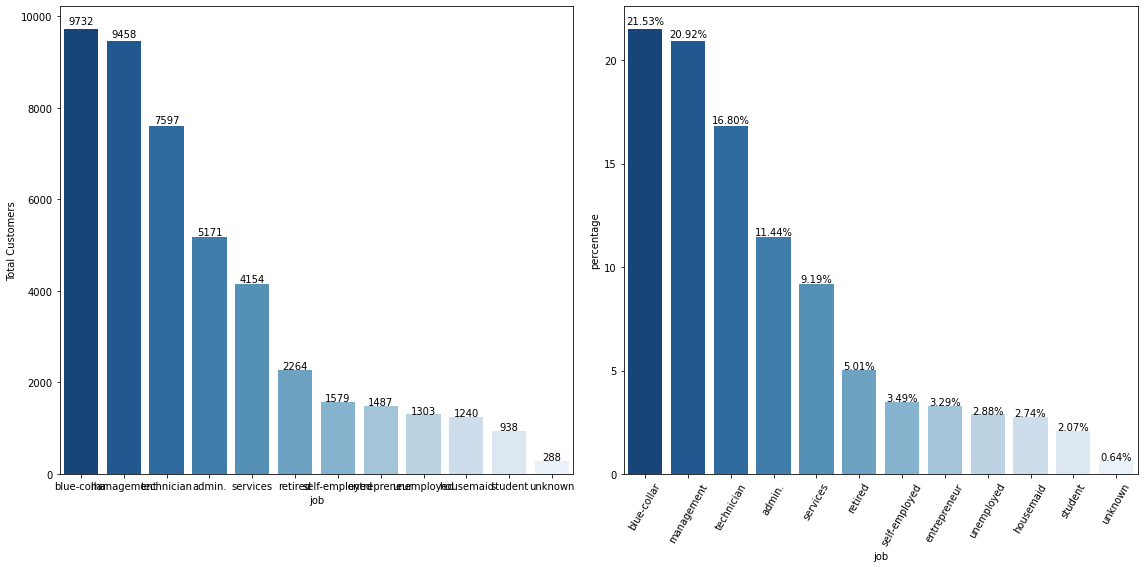

In [ ]:
plot_bar_uni('job')
plt.tight_layout()

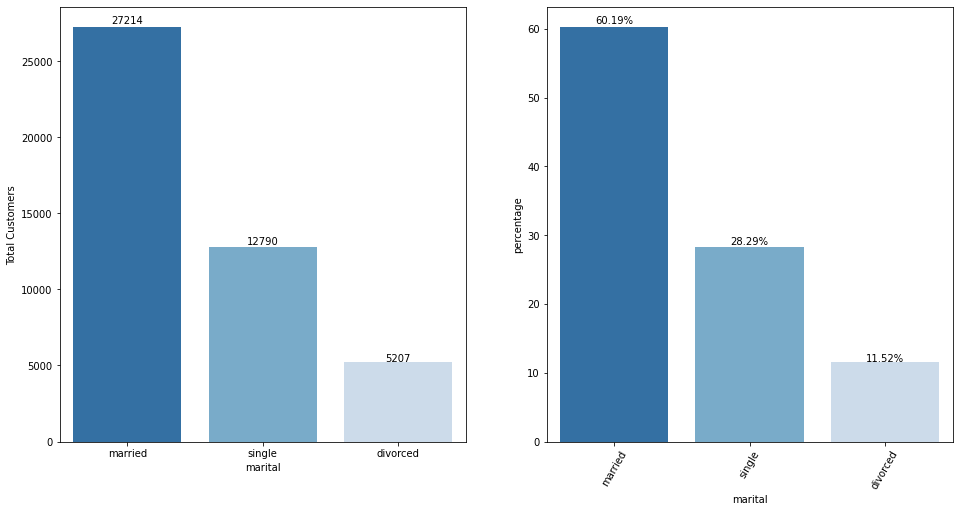

In [ ]:
plot_bar_uni('marital')

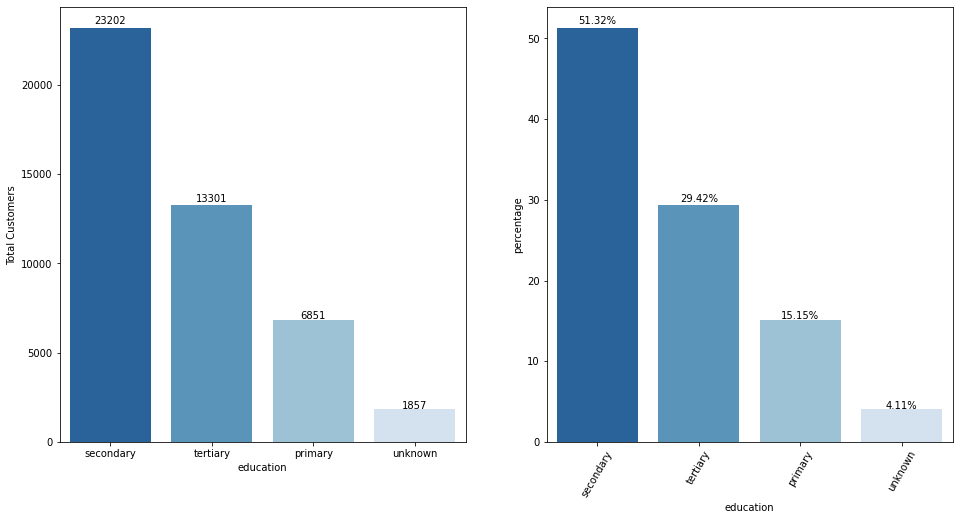

In [ ]:
plot_bar_uni('education')

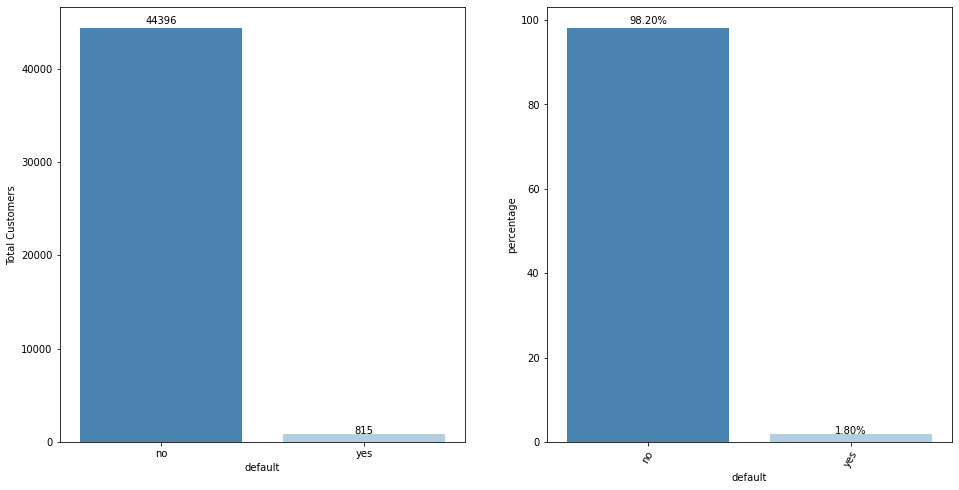

In [ ]:
plot_bar_uni('default')

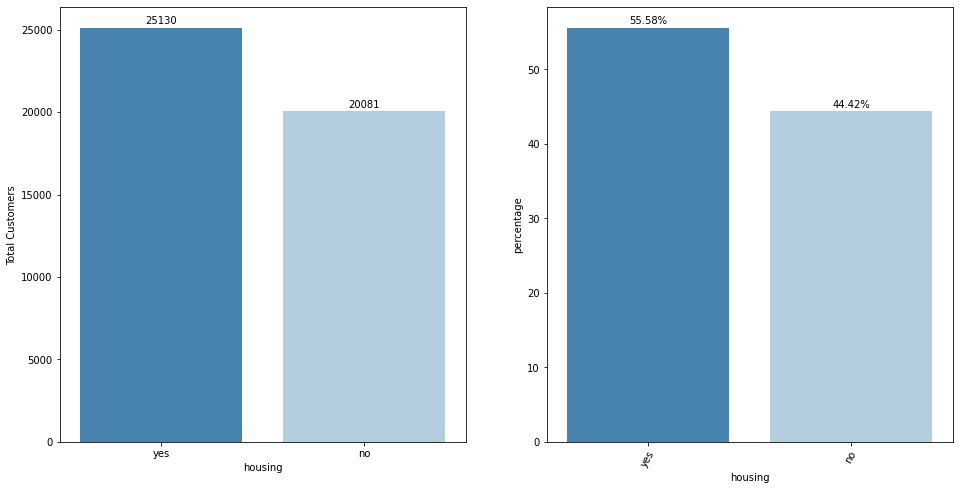

In [ ]:
plot_bar_uni('housing')

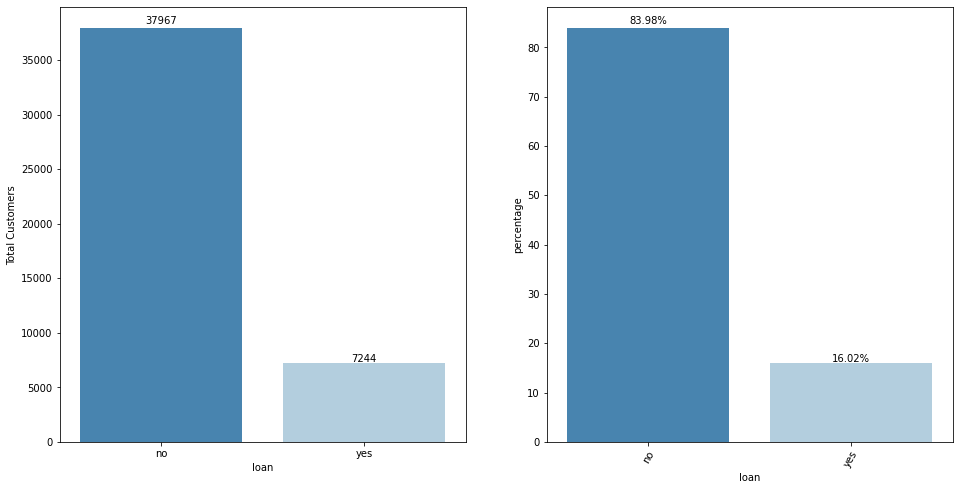

In [ ]:
plot_bar_uni('loan')

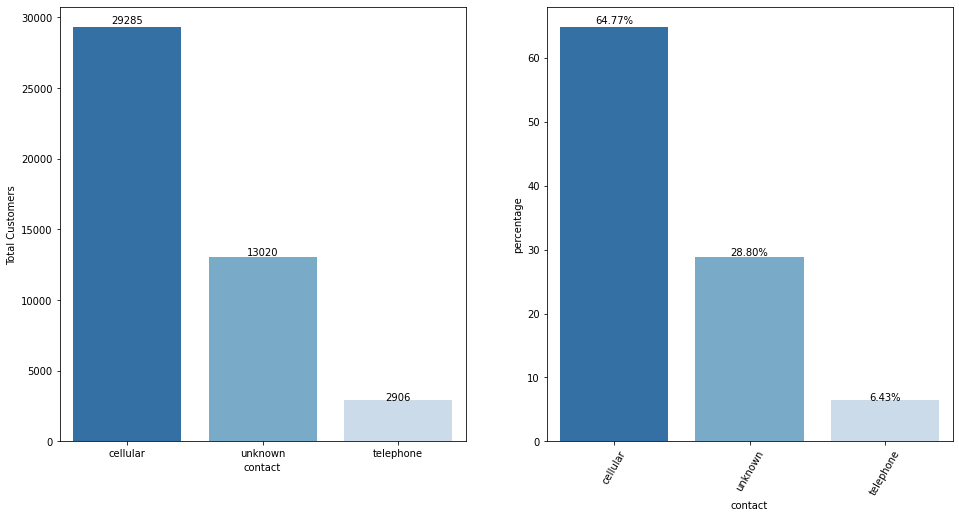

In [ ]:
plot_bar_uni('contact')

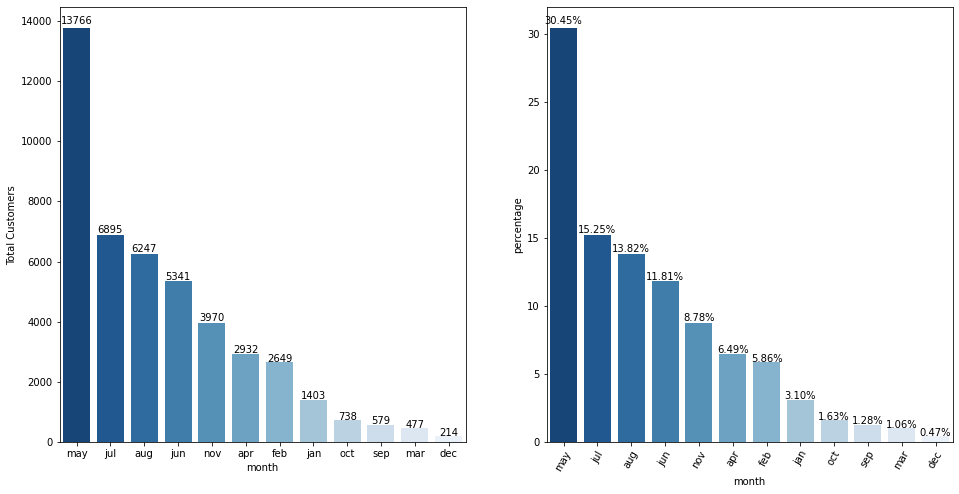

In [ ]:
plot_bar_uni('month')

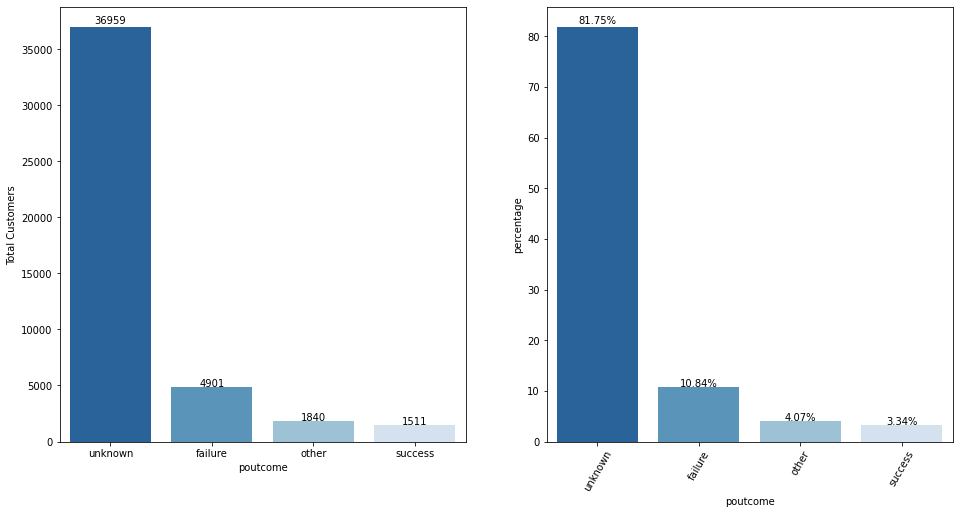

In [ ]:
plot_bar_uni('poutcome')

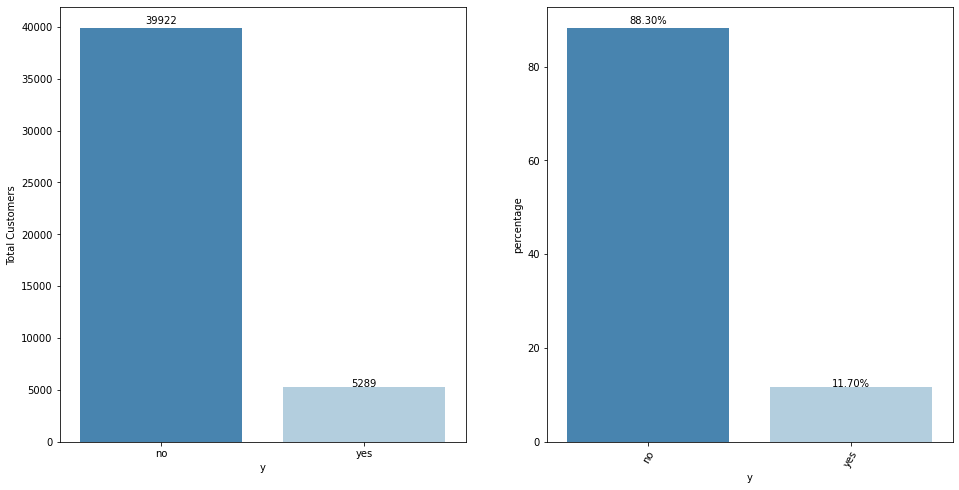

In [ ]:
plot_bar_uni('y')

Insights:
- Majority of customers are married
- Majority of customers have secondary education
- Majority of customers have no default
- Majority of customers have housing loan
- Majority of customers have personal loan
- Majority of contact communication type is cellular
- Majority of customers are contacted on May
- Majority of outcome of previous marketing campaign are unknown
- Majority of customers didn't subscribe on the deposite

To do:
- Fitur target (`y`) masih berbentuk categoricals, maka diperlukan pre-processing untuk mengubahnya menjadi numericals dengan teknik feature encoding. Hal ini akan memudahkan kita nantinya dalam melihat correlation antar fitur dan melakukan prediksi dengan algoritma machine learning.
- Pada fitur target terlihat bahwa data mengalami class imbalance. Perlu dilakukan imbalanced handling pada saat data pre-processing.

## Multivariate Analysis
Kita akan melihat visualisasi seluruh fitur berdasarkan subscribe atau tidaknya pada deposito

### Correlation

In [ ]:
# Ubah type data target y
df_copy = df.copy()

y_map = {
    'yes' : 1,
    'no' : 0
}

df_copy['y_map'] = df['y'].map(y_map)
df_copy.sample(7)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,y_map
38428,28,services,single,secondary,no,341,yes,no,cellular,15,may,437,3,347,3,other,yes,1
23638,45,blue-collar,married,secondary,no,-183,yes,yes,cellular,28,aug,8,13,-1,0,unknown,no,0
19889,55,self-employed,married,primary,no,0,no,no,cellular,8,aug,138,2,-1,0,unknown,no,0
14478,31,admin.,married,secondary,no,23,no,no,cellular,14,jul,77,3,-1,0,unknown,no,0
11145,48,management,single,tertiary,no,0,no,no,unknown,18,jun,96,3,-1,0,unknown,no,0
29465,28,entrepreneur,married,tertiary,no,59,no,no,cellular,3,feb,330,3,190,6,failure,no,0
37315,43,management,divorced,secondary,no,229,yes,yes,cellular,13,may,163,1,-1,0,unknown,no,0


In [ ]:
df_copy.corr()

,age,balance,day,duration,campaign,pdays,previous,y_map
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,-0.023758,0.001288,0.025155
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674,0.052838
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710,-0.028348
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,-0.001565,0.001203,0.394521
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.088628,-0.032855,-0.073172
pdays,-0.023758,0.003435,-0.093044,-0.001565,-0.088628,1.000000,0.454820,0.103621
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,0.454820,1.000000,0.093236
y_map,0.025155,0.052838,-0.028348,0.394521,-0.073172,0.103621,0.093236,1.000000


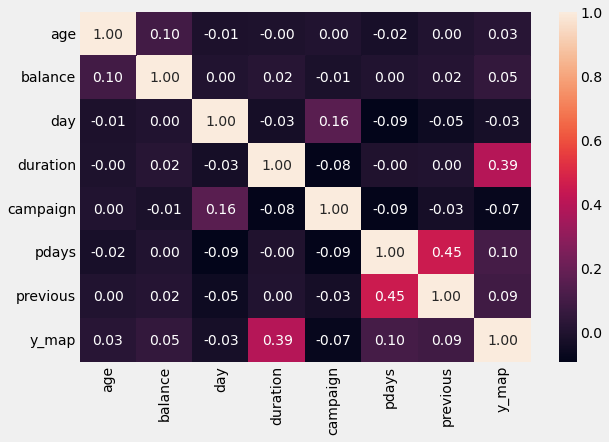

In [ ]:
plt.figure(figsize = (9,6))
sns.heatmap(df_copy.corr(), annot = True, fmt = '.2f');

Berdasarkan heatmap di atas, ada beberapa insights yang dapat diambil:
- `duration` memiliki nilai korelasi yang lumayan tinggi terhadap `y` (subscribe). `duration` diduga menjadi salah satu fitur yang berpengaruh untuk memprediksi subscribe tidaknya customer pada deposit
- Fitur lainnya berkorelasi rendah terhadap `y`
- Tidak ada korelasi yang tinggi antar fitur-fitur selain fitur target, sehingga kita tidak perlu mengkhawatirkan terkait multikolinearitas
- Semua fitur akan dipertahankan

In [ ]:
plt.style.use('fivethirtyeight')

In [ ]:
def group_df_churn(col):
    ndf = df.groupby([col, 'y']).agg({'age':'count'}).reset_index() # 'customer_id':'nunique'
    ndf_sum = ndf.groupby(col).agg({'age':'sum'}) # 'customer_id':'sum'
    ndf = ndf.merge(ndf_sum, on = col)
    ndf['percentage'] = (ndf['age_x']/ndf['age_y']) * 100
    return ndf

def plot_continuous(col):
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,8))
    sns.boxplot(x = 'y', y = col, data = df, ax = ax[0])
    sns.histplot(x = col, hue = 'y', data = df, ax = ax[1])

def plot_box(col):
    df1 = group_df_churn(col)
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,8))
    plt.xticks(rotation = 60)
    sns.barplot(x = col, y= 'age_x', hue = 'y', data = df1, ax = ax[0],
               #order = df1.iloc[df1[df1['y'] == "yes"]['percentage'].sort_values(ascending = False).index](col)
               )
    ax[0].set_ylabel('Total Customer')
    show_val_int(ax[0])
    sns.barplot(x = col, y= 'percentage', hue = 'y', data = df1, ax = ax[1],
               #order = df1.iloc[df1[df['y'] == "yes"]['percentage'].sort_values(ascending = False).index](col)
               )
    show_val_percent(ax[1])

### Numerical

In [ ]:
num_cols

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

#### Age

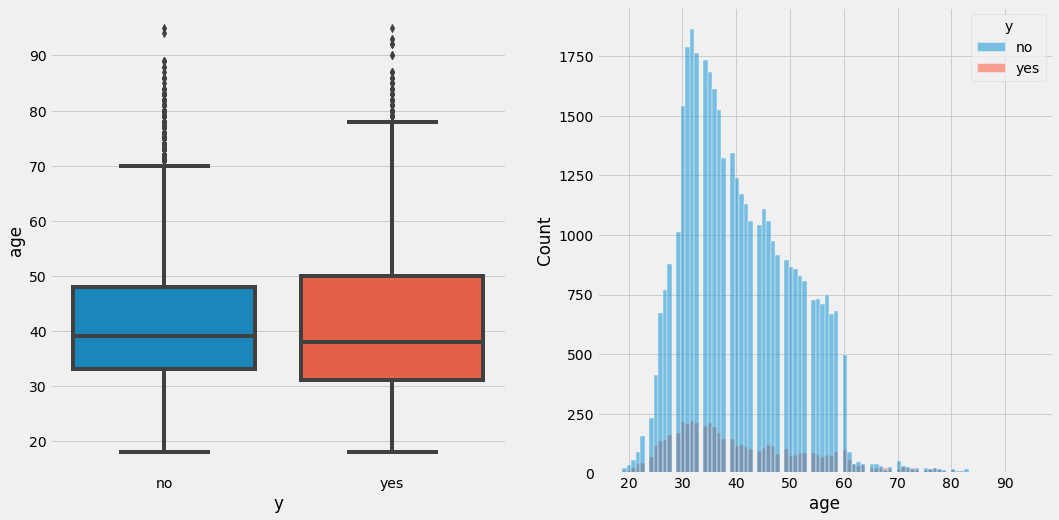

In [ ]:
plot_continuous('age')

#### Balance

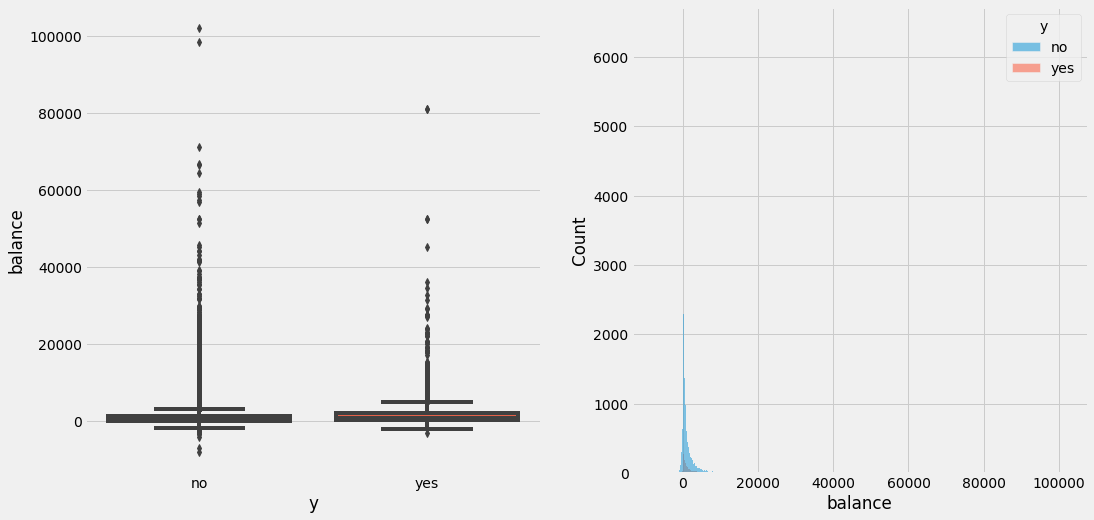

In [ ]:
plot_continuous('balance')

#### Day

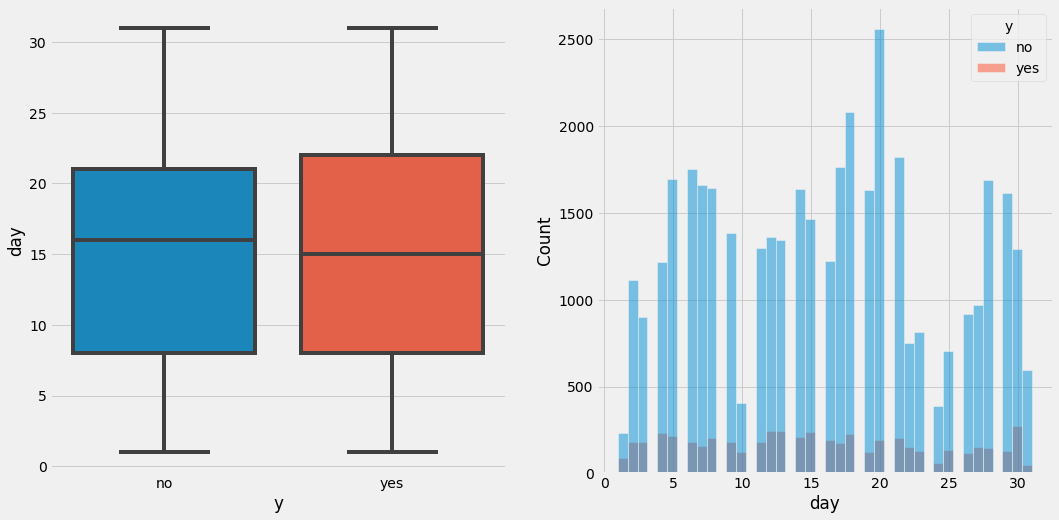

In [ ]:
plot_continuous('day')

#### Duration

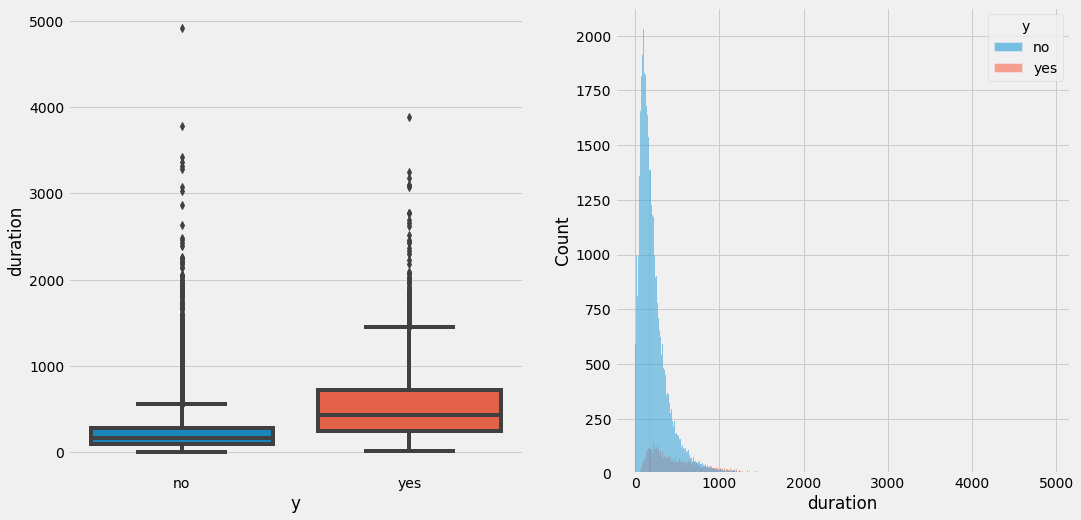

In [ ]:
plot_continuous('duration')

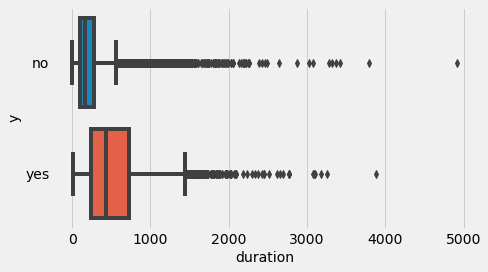

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(7, 4))
ax = sns.boxplot(
x = df['duration'],
y = df['y'],)
ax.set_xlabel('duration', fontsize = 14)
ax.set_ylabel('y', fontsize = 14)
ax.tick_params(labelsize=14)
plt.tight_layout()
plt.show()
plt.savefig('edaduration')

In [ ]:
df['duration'].groupby(df['y']).describe()

,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
no,39922.0,221.182806,207.383237,0.0,95.0,164.0,279.0,4918.0
yes,5289.0,537.294574,392.525262,8.0,244.0,426.0,725.0,3881.0


In [ ]:
df[['duration']].describe()

,duration
count,45211.000000
mean,258.163080
std,257.527812
min,0.000000
25%,103.000000
50%,180.000000
75%,319.000000
max,4918.000000


Duration memiliki korelasi yang cukup tinggi dengan y (subscribe). Duration diduga merupakan fitur yang sangat krusial/menentukan dalam menawarkan deposito kepada customer. Berdasarkan plot, kita dapat melihat bahwa customer cenderung menolak tawaran deposito pada menit-menit awal (durasi yang singkat) dan menerima (subscribe) apabila durasi telponnya lebih lama.

Business recommendation:
1. Harus dicek apa saja yg sudah disampaikan oleh tim sales/customer success pada menit-menit awal. Ketika tidak mendapatkan atensi pada menit-menit awal, maka customer akan menolak. Ketika kita bisa mendapatkan atensi dan menyampaikan informasi dengan baik di menit-menit awal, maka ada potensi customer akan subscribe
2. Menstandarisasi teks yang akan kita sampaikan ke customer
3. Karena produk kita sebenarnya bagus dan artinya mereka yg sudah memakai produk kita retention ratenya tinggi. Maka bisa jadi business rekomendasi kedua, yaitu testimoni produk dari pengguna sebelumnya 2-3 menit awal penyampaian benefit dan testimoni

#### Campaign

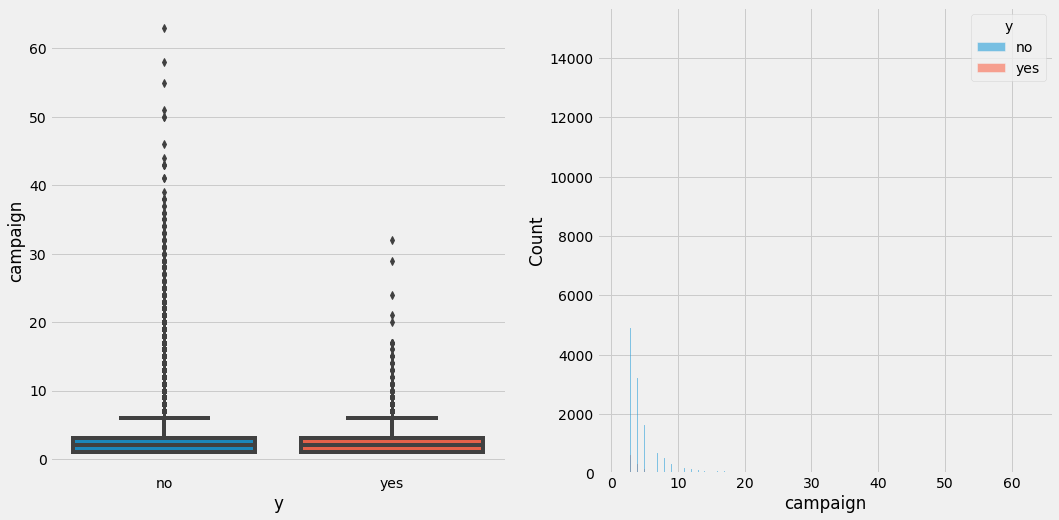

In [ ]:
plot_continuous('campaign')

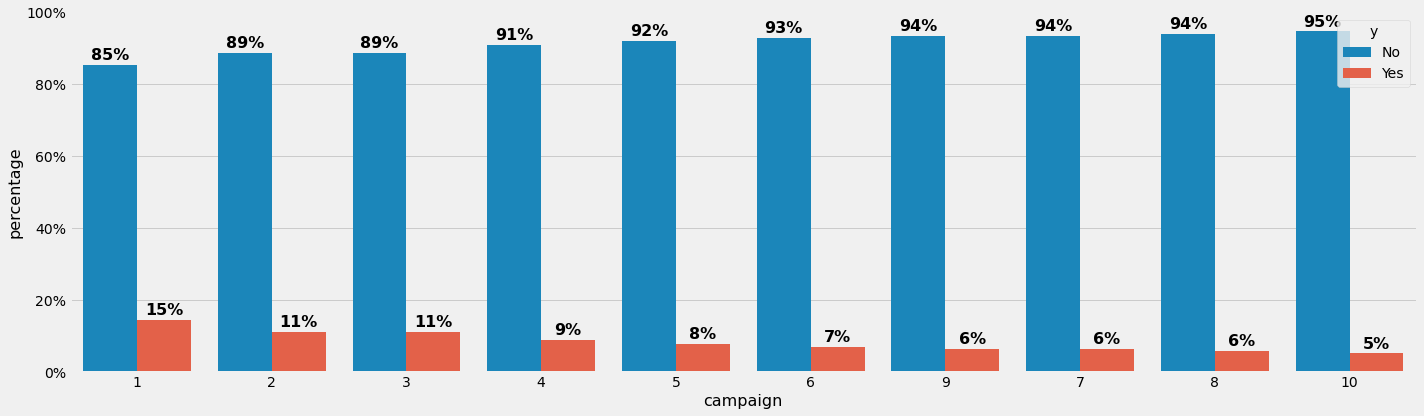

In [ ]:
plt.style.use('fivethirtyeight')

# create percentage df
dist = df[df['campaign'] <= 10].groupby(['campaign', 'y']).count()[["age"]]
cat_group = df[df['campaign'] <= 10].groupby('campaign').count()[["age"]]
dist["percentage"] = dist.div(cat_group, level = 'campaign') * 100
dist.reset_index(inplace = True)
dist.columns = ["campaign", "y", "count", "percentage"]

# plot
plt.figure(figsize=(20,6))
ax = sns.barplot(
     x = 'campaign',
     y = "percentage",
     hue = "y",
     data = dist,
     order = dist.iloc[dist[dist['y'] == "yes"]['percentage'].sort_values(ascending = False).index]['campaign'],
    )

# set yticks format to percentage
y_ = [x for x in range(0, 120, 20)]
plt.yticks(y_)
ylabels = [format(y) + '%' for y in ax.get_yticks()]
ax.set_yticklabels(labels = ylabels);

# annotate bar
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.0f') + "%",
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha = 'center',
        fontweight = 'semibold',
        size = 16,
        xytext = (0, 5), 
        textcoords = 'offset points'
        )
    
# set legend label
L = ax.legend(loc='upper right', title="y")
L.get_texts()[0].set_text('No')
L.get_texts()[1].set_text('Yes')
    
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('campaign', fontsize=16)
plt.ylabel('percentage', fontsize=16)
plt.tight_layout();

Jumlah campaign 1-3 tampaknya adalah jumlah yang ideal agar customer subscribe ke term deposit. Tim marketing harus menemukan metode campaign  yang optimal agar customer mau untuk subscribe cukup dengan 1 sampai 3 kali campaign/penawaran

#### Pdays

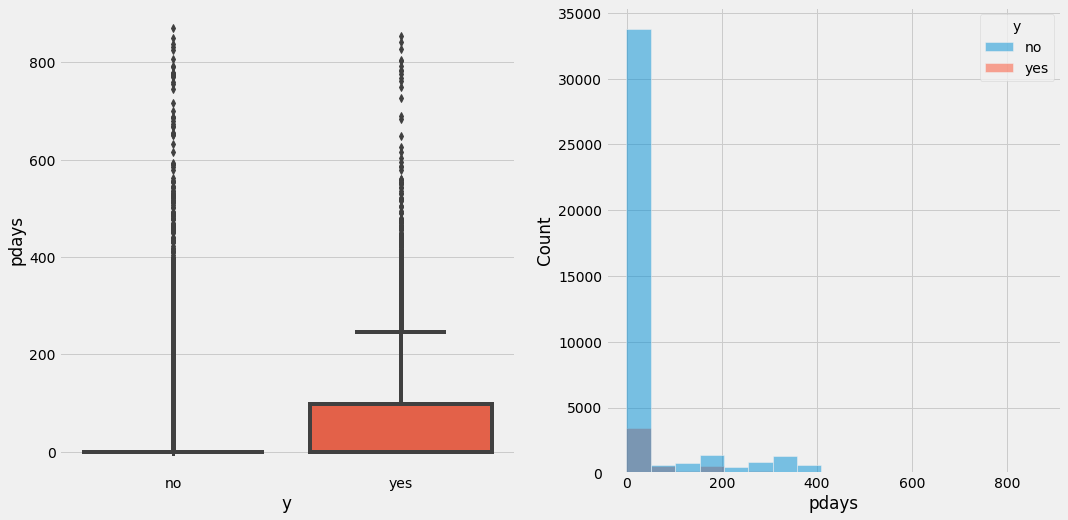

In [ ]:
plot_continuous('pdays')

#### Previous

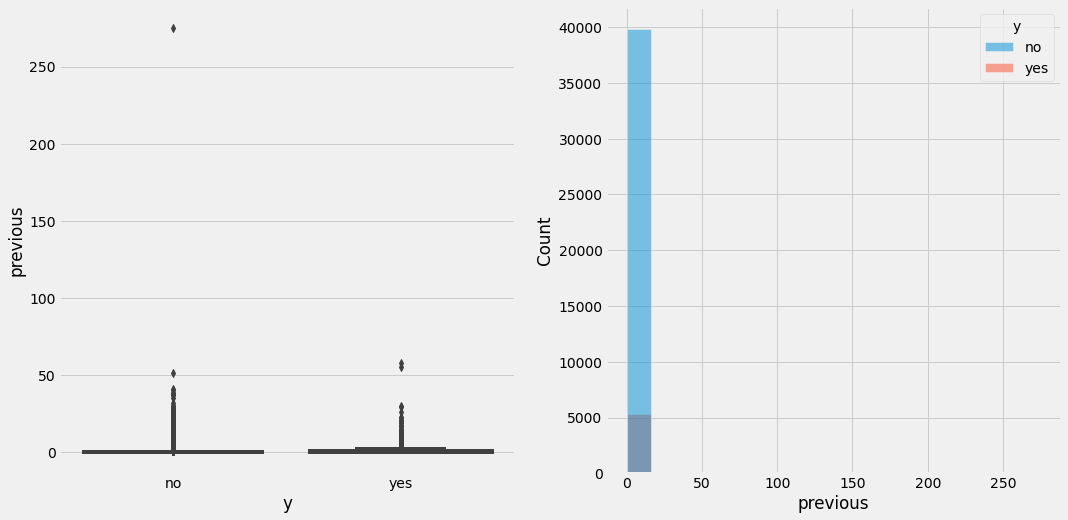

In [ ]:
plot_continuous('previous')

### Categorical

In [ ]:
cat_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'y']

#### Job

Pada fitur `job`, presentase subscribe yang paling besar terdapat pada **student** (siswa) dan **retired** (pensiunan)

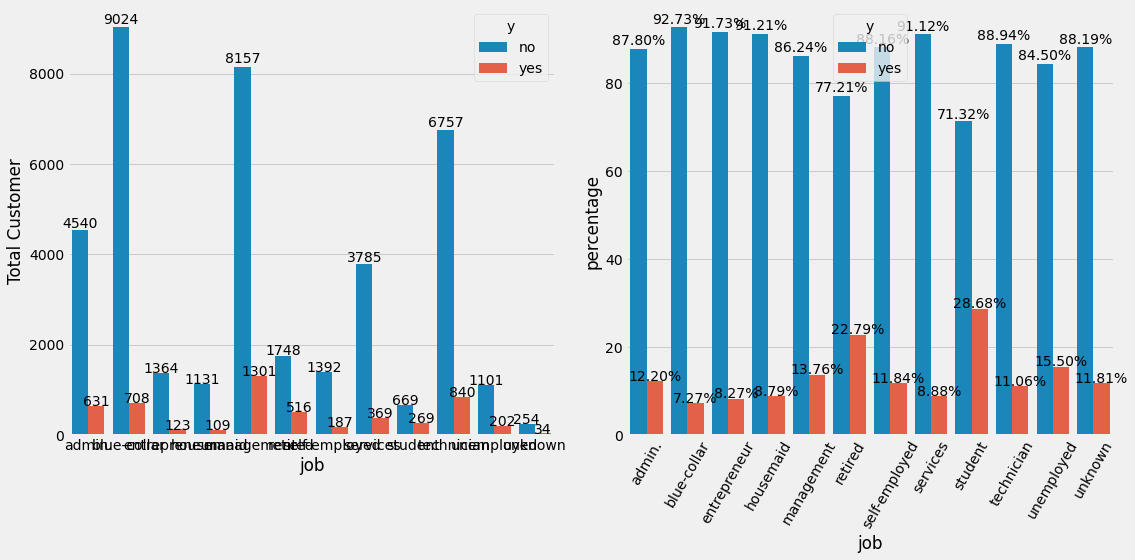

In [ ]:
plot_box('job')
plt.tight_layout()

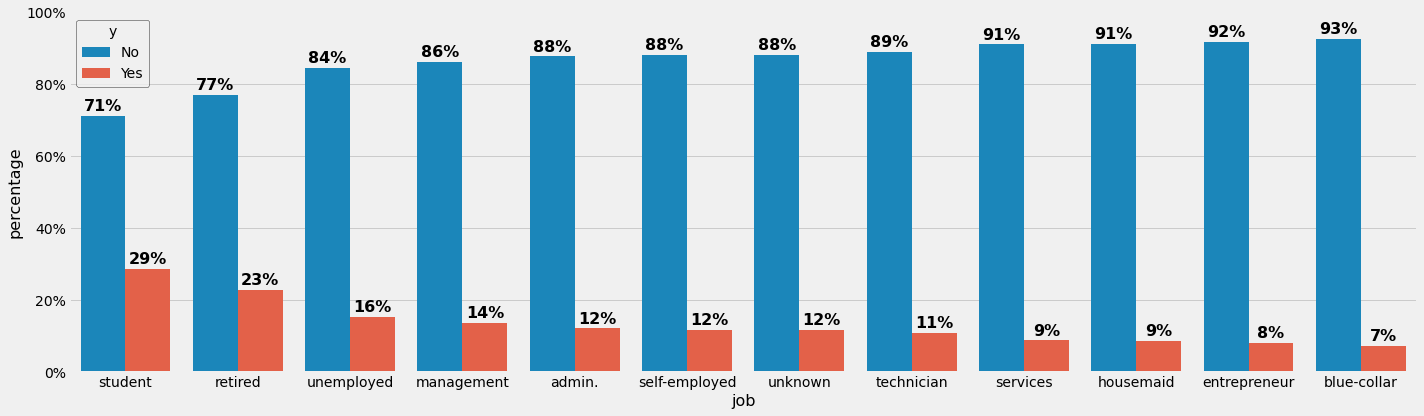

In [ ]:
# create percentage df
dist = df.groupby(['job', "y"]).count()[["age"]]
cat_group = df.groupby('job').count()[["age"]]
dist["percentage"] = dist.div(cat_group, level = 'job') * 100
dist.reset_index(inplace = True)
dist.columns = ["job", "y", "count", "percentage"]

# plot
plt.figure(figsize=(20,6))
ax = sns.barplot(
     x = 'job',
     y = "percentage",
     hue = "y",
     data = dist,
     order = dist.iloc[dist[dist['y'] == "yes"]['percentage'].sort_values(ascending = False).index]['job'],
    )

# set yticks format to percentage
y_ = [x for x in range(0, 120, 20)]
plt.yticks(y_)
ylabels = [format(y) + '%' for y in ax.get_yticks()]
ax.set_yticklabels(labels = ylabels);

# annotate bar
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.0f') + "%",
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha = 'center',
        fontweight = 'semibold',
        size = 16,
        xytext = (0, 5), 
        textcoords = 'offset points',
        color = 'black'
        )

# set legend label
L = ax.legend(edgecolor='black', title="y")
L.get_texts()[0].set_text('No')
L.get_texts()[1].set_text('Yes')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('job', fontsize=16)
plt.ylabel('percentage', fontsize=16)
plt.tight_layout();

#### Marital
Pada fitur `marital`, presentase subscribe yang paling besar terdapat pada customer dengan status **single**, tetapi perbedaannya tidak terlalu jauh dengan nilai yang lain.

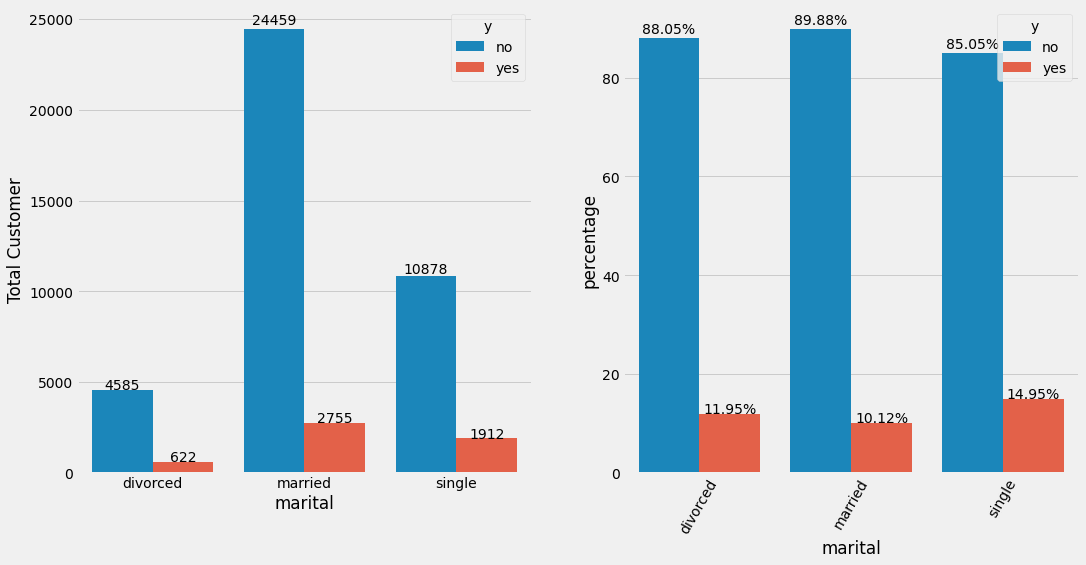

In [ ]:
plot_box('marital')

#### Education

Pada fitur `education`, terlihat bahwa jenjang pendidikan yang lebih tinggi mempunyai presentase subscribe yang lebih besar. Dapat kita lakukan label encoding pada pre-processing data. Namun terdapat sedikit masalah dengan adanya 'unknown' value pada fitur ini

Setelah ditelusuri lebih jauh, didapatkan data tingkatan pendidikan (education) dengan urutan pekerjaan (job) dari yang terbanyak sebagai berikut:
1. Primary -> blue-collar, retired, housemaid, services, management, unemployed, ...
2. Secondary -> blue-collar, technician, admin, services, management, retired, ...
3. Tertiary -> management, technician, self-employed, entrepreneur, admin, ...
4. Unknown -> blue-collar, management, technician, admin, student, services, ...

Unknown value banyak memiliki kemiripan dengan Secondary pada status pekerjaannya dengan terdapat banyak nilai blue-collar, technician, admin, services. Unknown value juga memiliki nilai management yang banyak pada status pekerjaannya seperti Tertiary. Melihat hal tersebut, kami memutuskan mengurutkannya (ascending) pada label encoding menjadi:
1. primary : 0
2. secondary : 1
3. unknown : 2
4. tertiary : 3

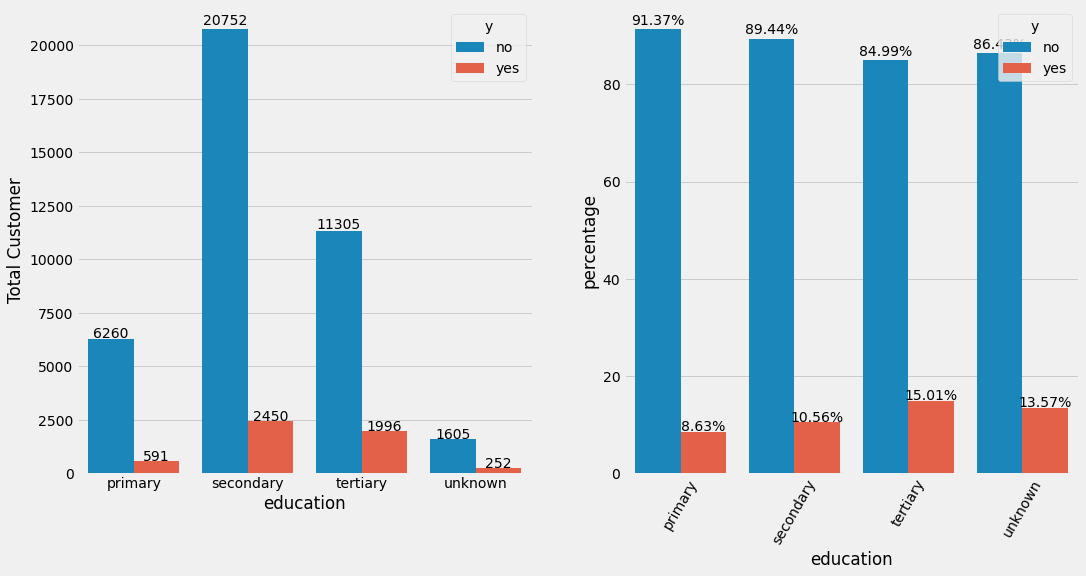

In [ ]:
plot_box('education')

In [ ]:
df.groupby(['education', "job"]).count()[["age"]].sort_values('age', ascending=False)

age
education job                
tertiary  management     7801
secondary blue-collar    5371
          technician     5229
          admin.         4219
primary   blue-collar    3758
secondary services       3457
tertiary  technician     1968
secondary management     1121
          retired         984
tertiary  self-employed   833
primary   retired         795
secondary unemployed      728
tertiary  entrepreneur    686
primary   housemaid       627
secondary self-employed   577
tertiary  admin.          572
secondary entrepreneur    542
          student         508
unknown   blue-collar     454
secondary housemaid       395
tertiary  retired         366
primary   services        345
          management      294
tertiary  unemployed      289
primary   unemployed      257
unknown   management      242
          technician      242
tertiary  student         223
primary   admin.          209
tertiary  services        202
primary   entrepreneur    183
tertiary  housemaid       173
unknown   admin.          171
          student         163
primary   technician      158
unknown   services        150
tertiary  blue-collar     149
primary   self-employed   130
unknown   unknown         127
          retired         119
          entrepreneur     76
secondary unknown          71
primary   unknown          51
unknown   housemaid        45
primary   student          44
unknown   self-employed    39
tertiary  unknown          39
unknown   unemployed       29

#### Default
Pada fitur `default`, customer yang tidak gagal bayar (**no default**) memiliki presentase subscribe yang jauh lebih besar dibanding dengan yang gagal bayar (yes)

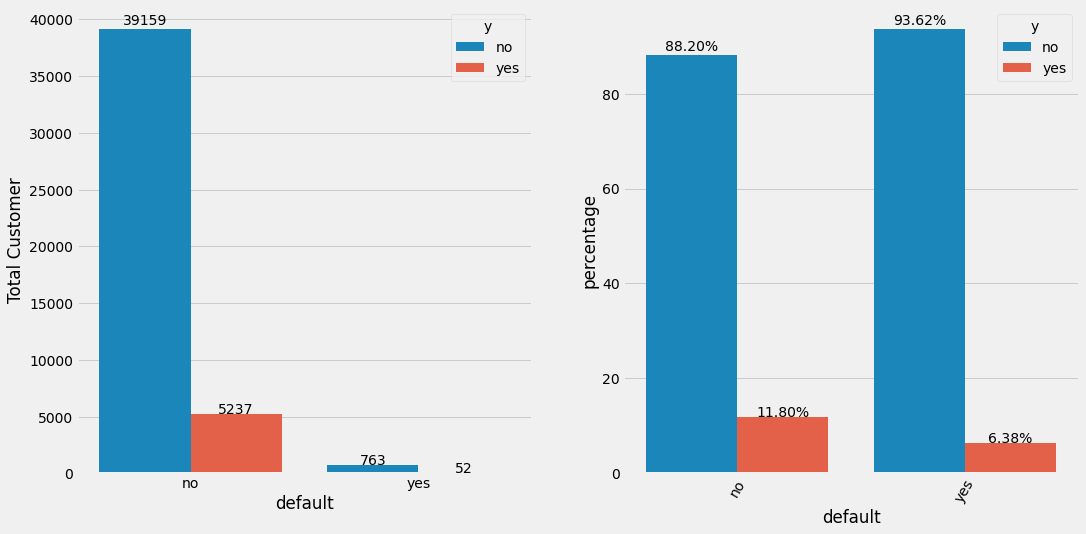

In [ ]:
plot_box('default')

#### Housing loan
Pada fitur `housing`, customer yang tidak memiliki pinjaman perumahan (**no housing**) memiliki presentase subscribe yang jauh lebih besar dibanding dengan yang memiliki pinjaman perumahan (yes)

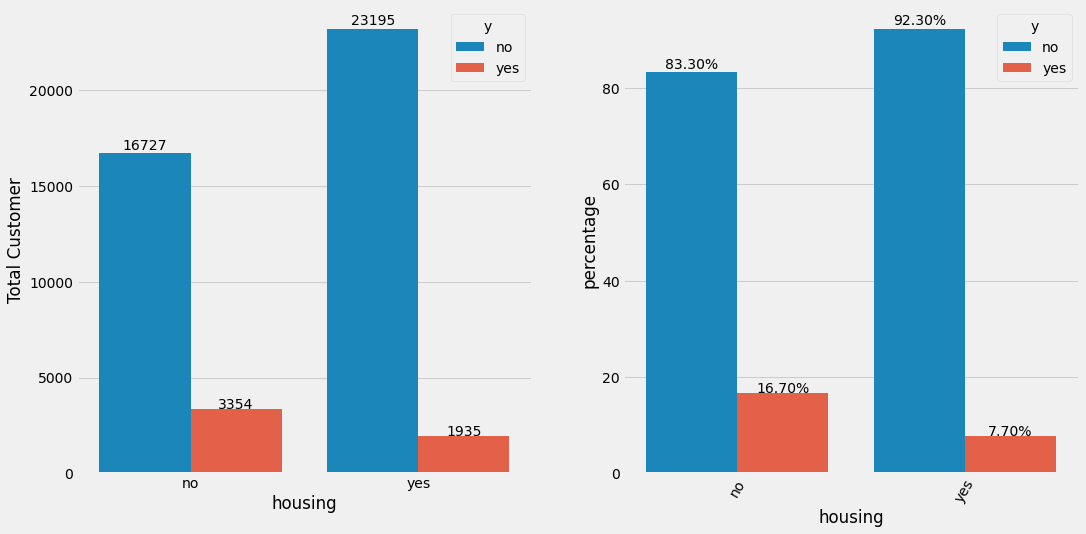

In [ ]:
plot_box('housing')

#### Loan
Pada fitur `loan`, customer yang tidak memiliki pinjaman (**no loan**) memiliki presentase subscribe yang jauh lebih besar dibanding dengan yang memiliki pinjaman (yes)

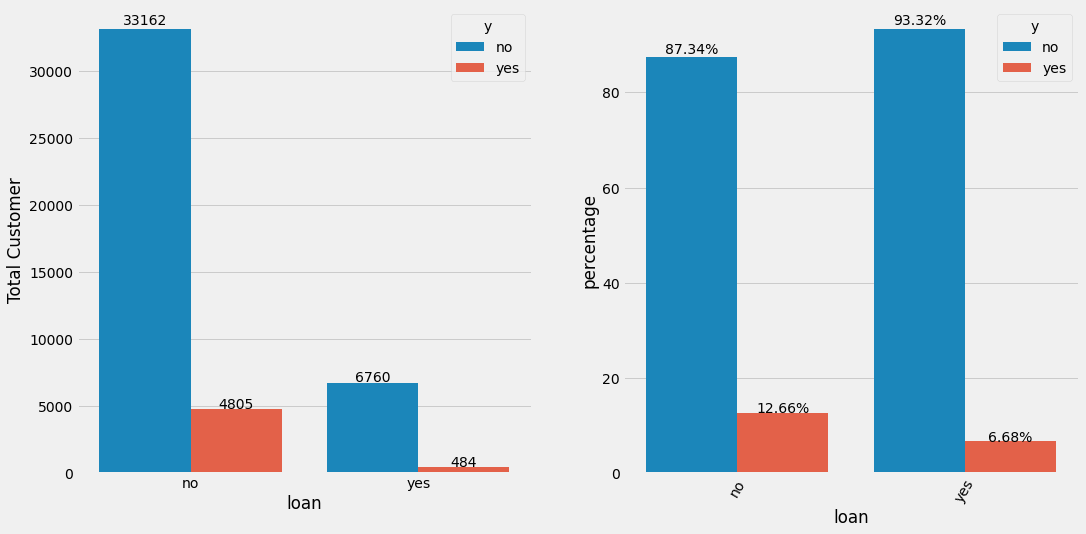

In [ ]:
plot_box('loan')

#### Contact
Pada fitur `contact`, customer dengan tipe **cellular** memiliki presentase subscribe yang jauh lebih besar dibanding tipe telephone

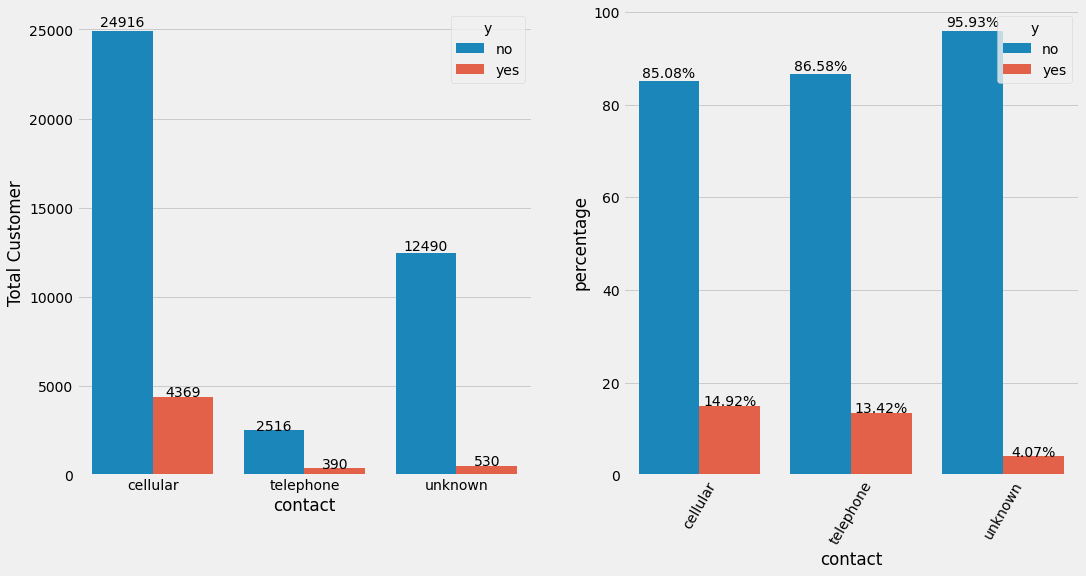

In [ ]:
plot_box('contact')

#### Month
Pada fitur `month`, presentase subscribe yang paling besar terdapat pada bulan **maret, september, oktober, dan desember**. Selain 4 bulan tersebut, jumlah campaign yang dilakukan kepada customer yang tidak potensial terlalu banyak. Hal ini dapat menyebabkan kerugian yang cukup besar, karena biaya untuk melakukan campign sangan besar tetapi feedback yang diperoleh (custumer yang subscibe) hanya sedikit.



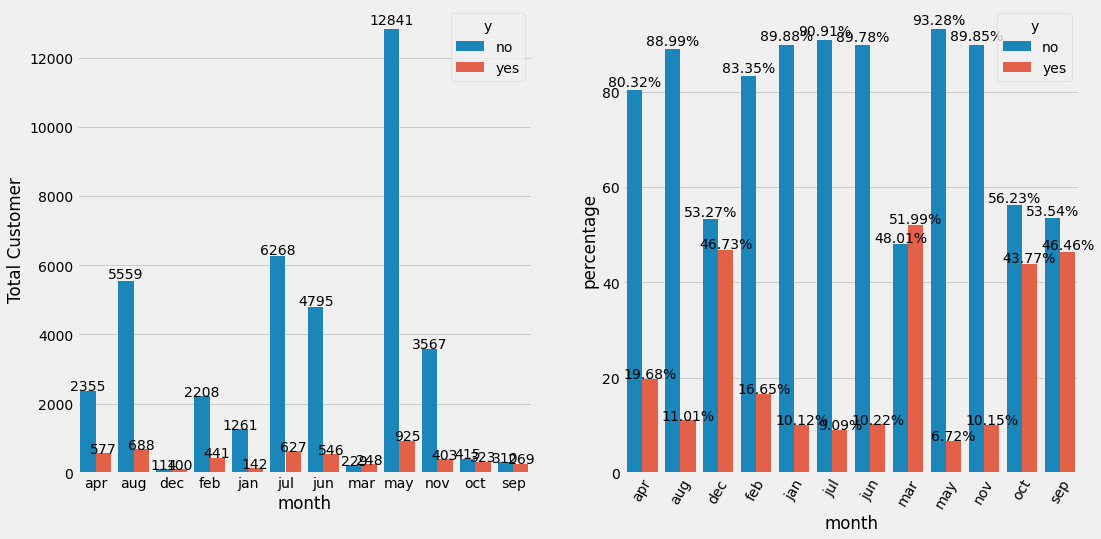

In [ ]:
plot_box('month')

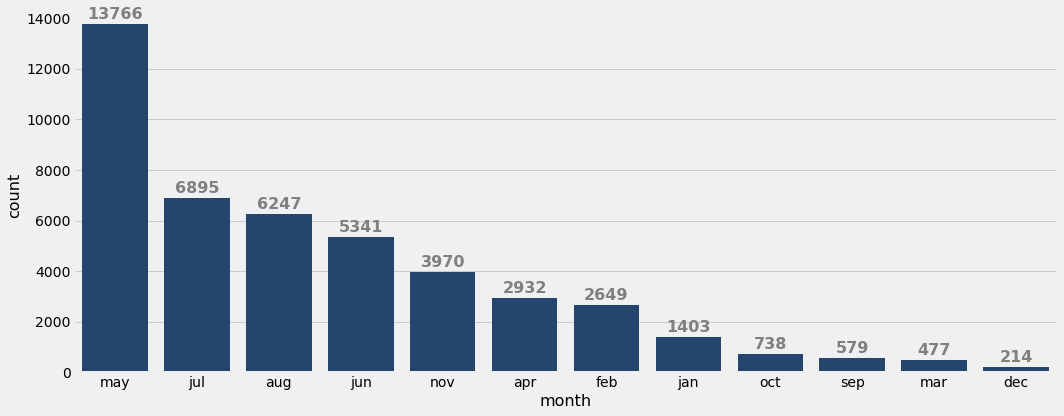

In [ ]:
# plot job features
plt.figure(figsize=(15,6))
ax = sns.countplot(
     x = df['month'],
     order = df['month'].value_counts().sort_values(ascending = False).index,
     color="#184578")
    
# annotate bar
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.0f'),
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha = 'center',
        fontweight = 'semibold',
        size = 16,
        xytext = (0, 5), 
        textcoords = 'offset points',
        color = 'grey'
        )

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('month', fontsize=16)
plt.ylabel('count', fontsize=16)
plt.ylim(0,14000)
plt.tight_layout()
plt.savefig('month')
plt.show();

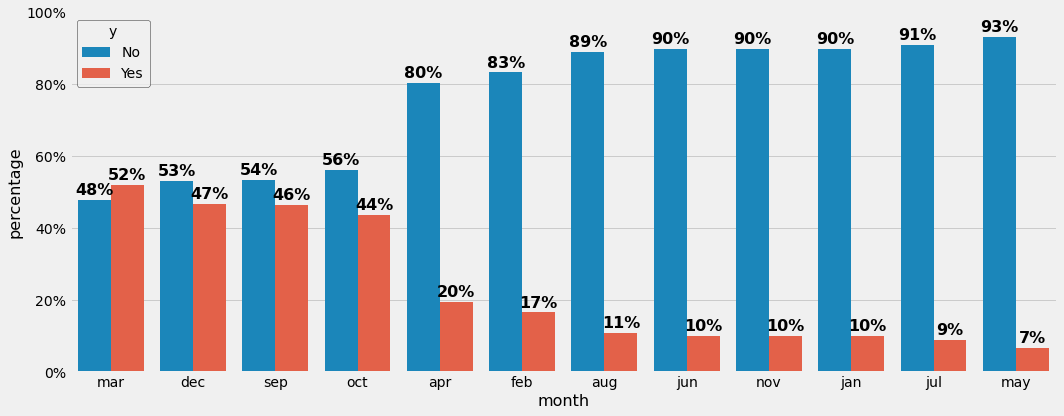

In [ ]:
# create percentage df
dist = df.groupby(['month', "y"]).count()[["age"]]
cat_group = df.groupby('month').count()[["age"]]
dist["percentage"] = dist.div(cat_group, level = 'month') * 100
dist.reset_index(inplace = True)
dist.columns = ["month", "y", "count", "percentage"]

# plot
plt.figure(figsize=(15,6))
ax = sns.barplot(
     x = 'month',
     y = "percentage",
     hue = "y",
     data = dist,
     order = dist.iloc[dist[dist['y'] == "yes"]['percentage'].sort_values(ascending = False).index]['month'],
    )

# set yticks format to percentage
y_ = [x for x in range(0, 120, 20)]
plt.yticks(y_)
ylabels = [format(y) + '%' for y in ax.get_yticks()]
ax.set_yticklabels(labels = ylabels);

# annotate bar
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.0f') + "%",
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha = 'center',
        fontweight = 'semibold',
        size = 16,
        xytext = (0, 5), 
        textcoords = 'offset points',
        color = 'black'
        )

# set legend label
L = ax.legend(edgecolor='black', title="y")
L.get_texts()[0].set_text('No')
L.get_texts()[1].set_text('Yes')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('month', fontsize=16)
plt.ylabel('percentage', fontsize=16)
plt.tight_layout();

#### Poutcome
Pada fitur `poutcome`, terlihat **previous outcome success** memiliki presentase subscribe yang paling besar dan jauh dari apabila dibandingkan dengan nilai lainnya.

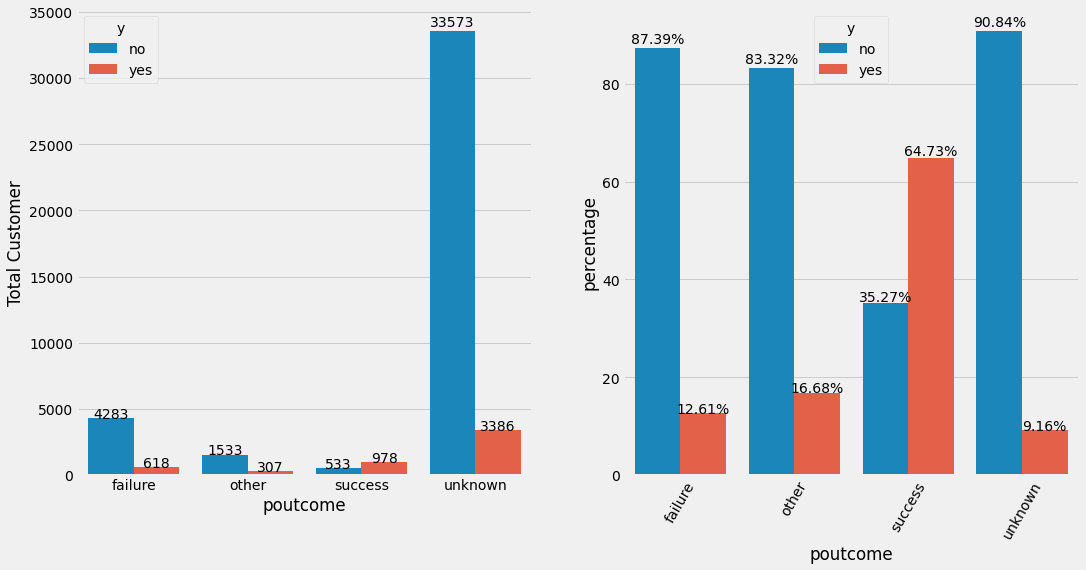

In [ ]:
plot_box('poutcome')

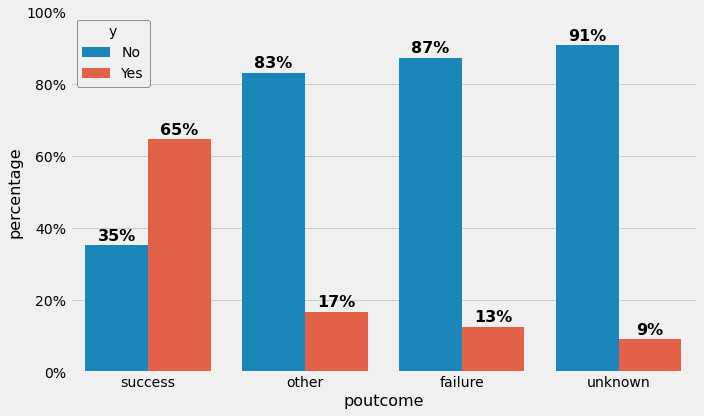

In [ ]:
# create percentage df
dist = df.groupby(['poutcome', "y"]).count()[["age"]]
cat_group = df.groupby('poutcome').count()[["age"]]
dist["percentage"] = dist.div(cat_group, level = 'poutcome') * 100
dist.reset_index(inplace = True)
dist.columns = ["poutcome", "y", "count", "percentage"]

# plot
plt.figure(figsize=(10,6))
ax = sns.barplot(
     x = 'poutcome',
     y = "percentage",
     hue = "y",
     data = dist,
     order = dist.iloc[dist[dist['y'] == "yes"]['percentage'].sort_values(ascending = False).index]['poutcome'],
    )

# set yticks format to percentage
y_ = [x for x in range(0, 120, 20)]
plt.yticks(y_)
ylabels = [format(y) + '%' for y in ax.get_yticks()]
ax.set_yticklabels(labels = ylabels);

# annotate bar
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.0f') + "%",
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha = 'center',
        fontweight = 'semibold',
        size = 16,
        xytext = (0, 5), 
        textcoords = 'offset points',
        color = 'black'
        )

# set legend label
L = ax.legend(edgecolor='black', title="y")
L.get_texts()[0].set_text('No')
L.get_texts()[1].set_text('Yes')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('poutcome', fontsize=16)
plt.ylabel('percentage', fontsize=16)
plt.tight_layout();

### Dist Plot

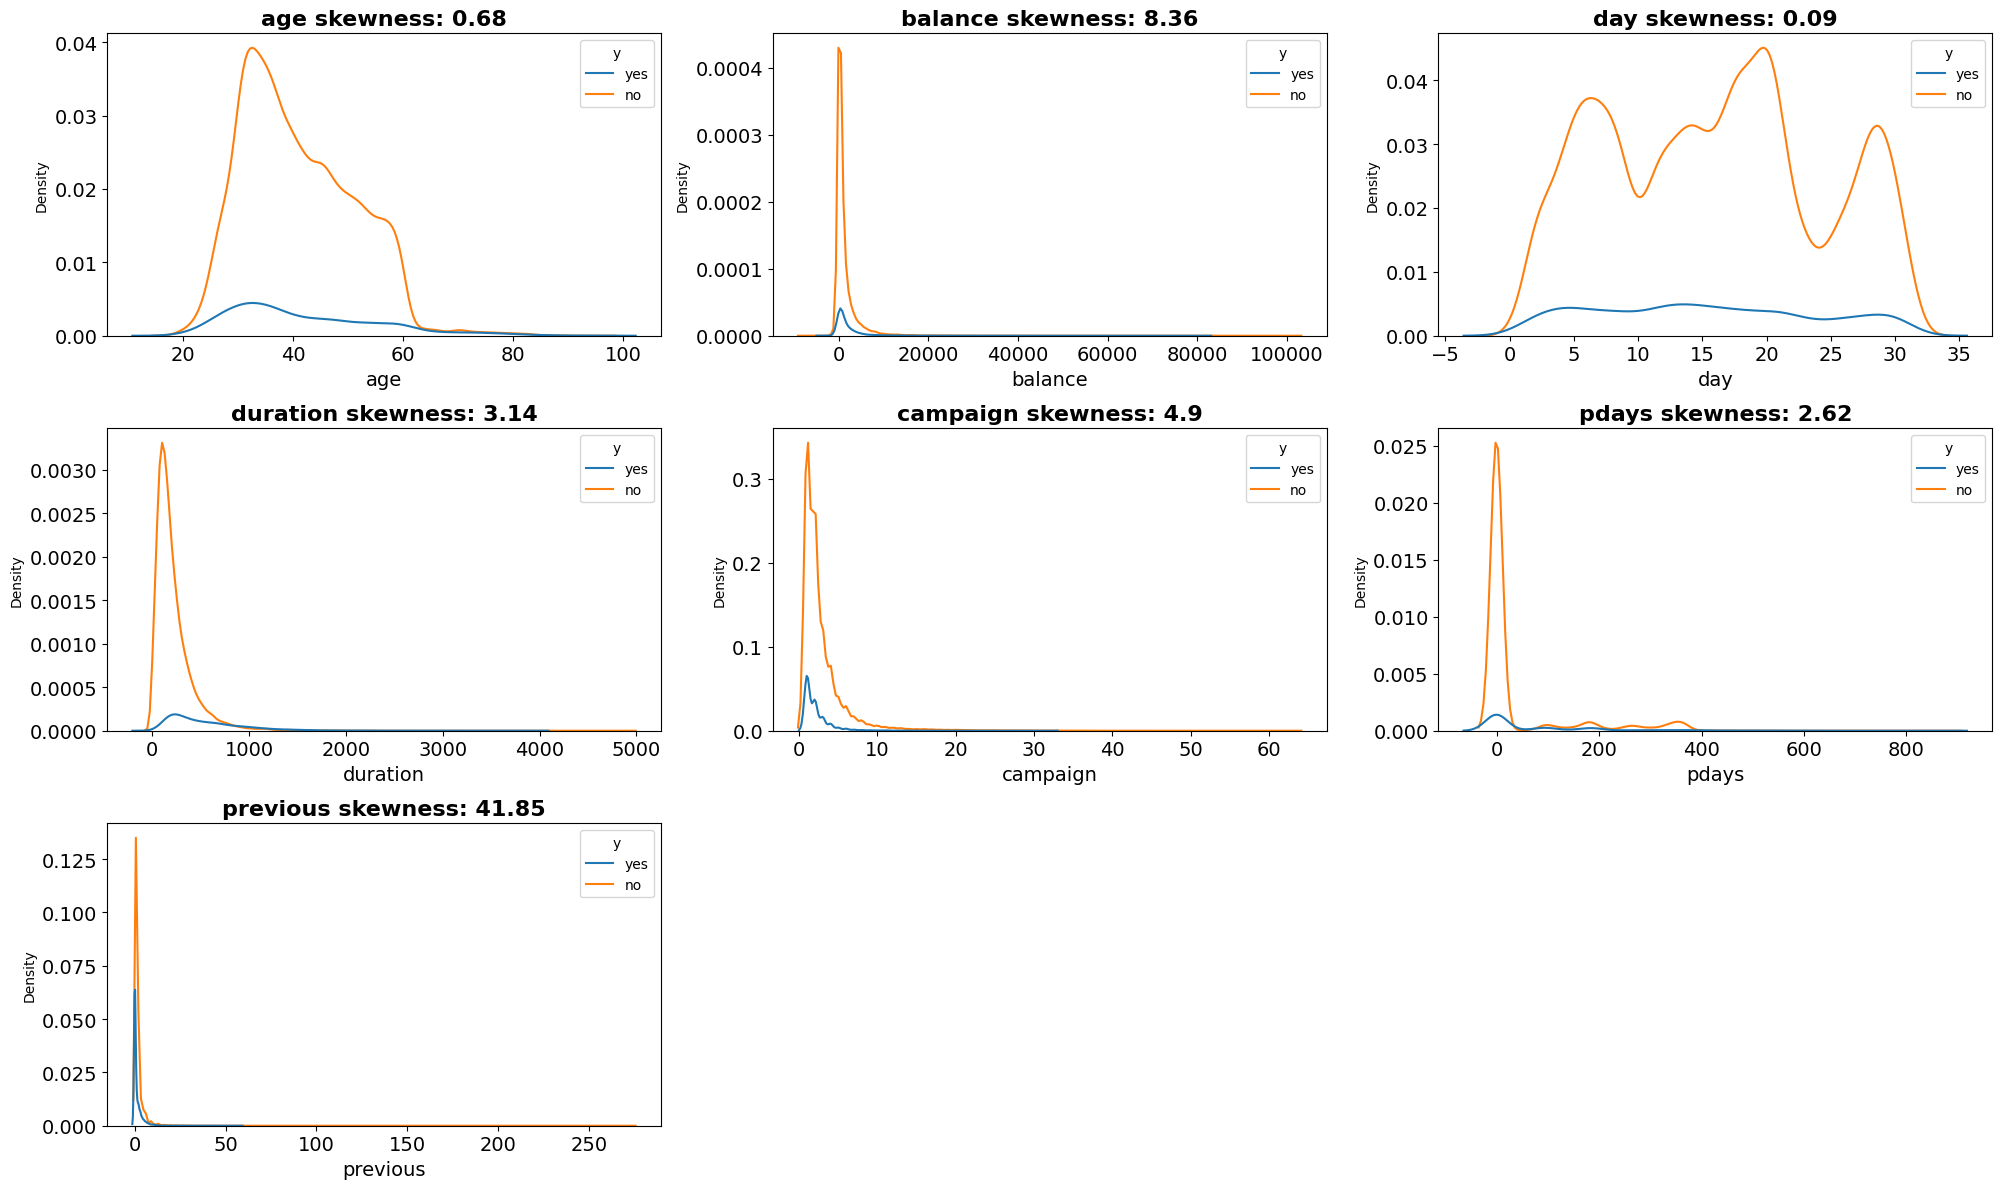

In [ ]:
plt.style.use('default')

nums_skewness = df[num_cols].skew()

plt.figure(figsize=(20, 12))
for i in range(len(num_cols)):
    plt.subplot(len(num_cols)//2, 3, i+1)
    ax = sns.kdeplot(
        df[num_cols[i]],
        hue = df['y'],
        hue_order = ['yes','no'])
    ax.set_xlabel(str(num_cols[i]), fontsize = 14)
    ax.tick_params(labelsize=14)
    ax.set_title(str(num_cols[i]) + ' skewness: ' + str(round(nums_skewness[i], 2)), fontsize=16, fontweight='heavy')
plt.tight_layout()
plt.show()

### Box Plot

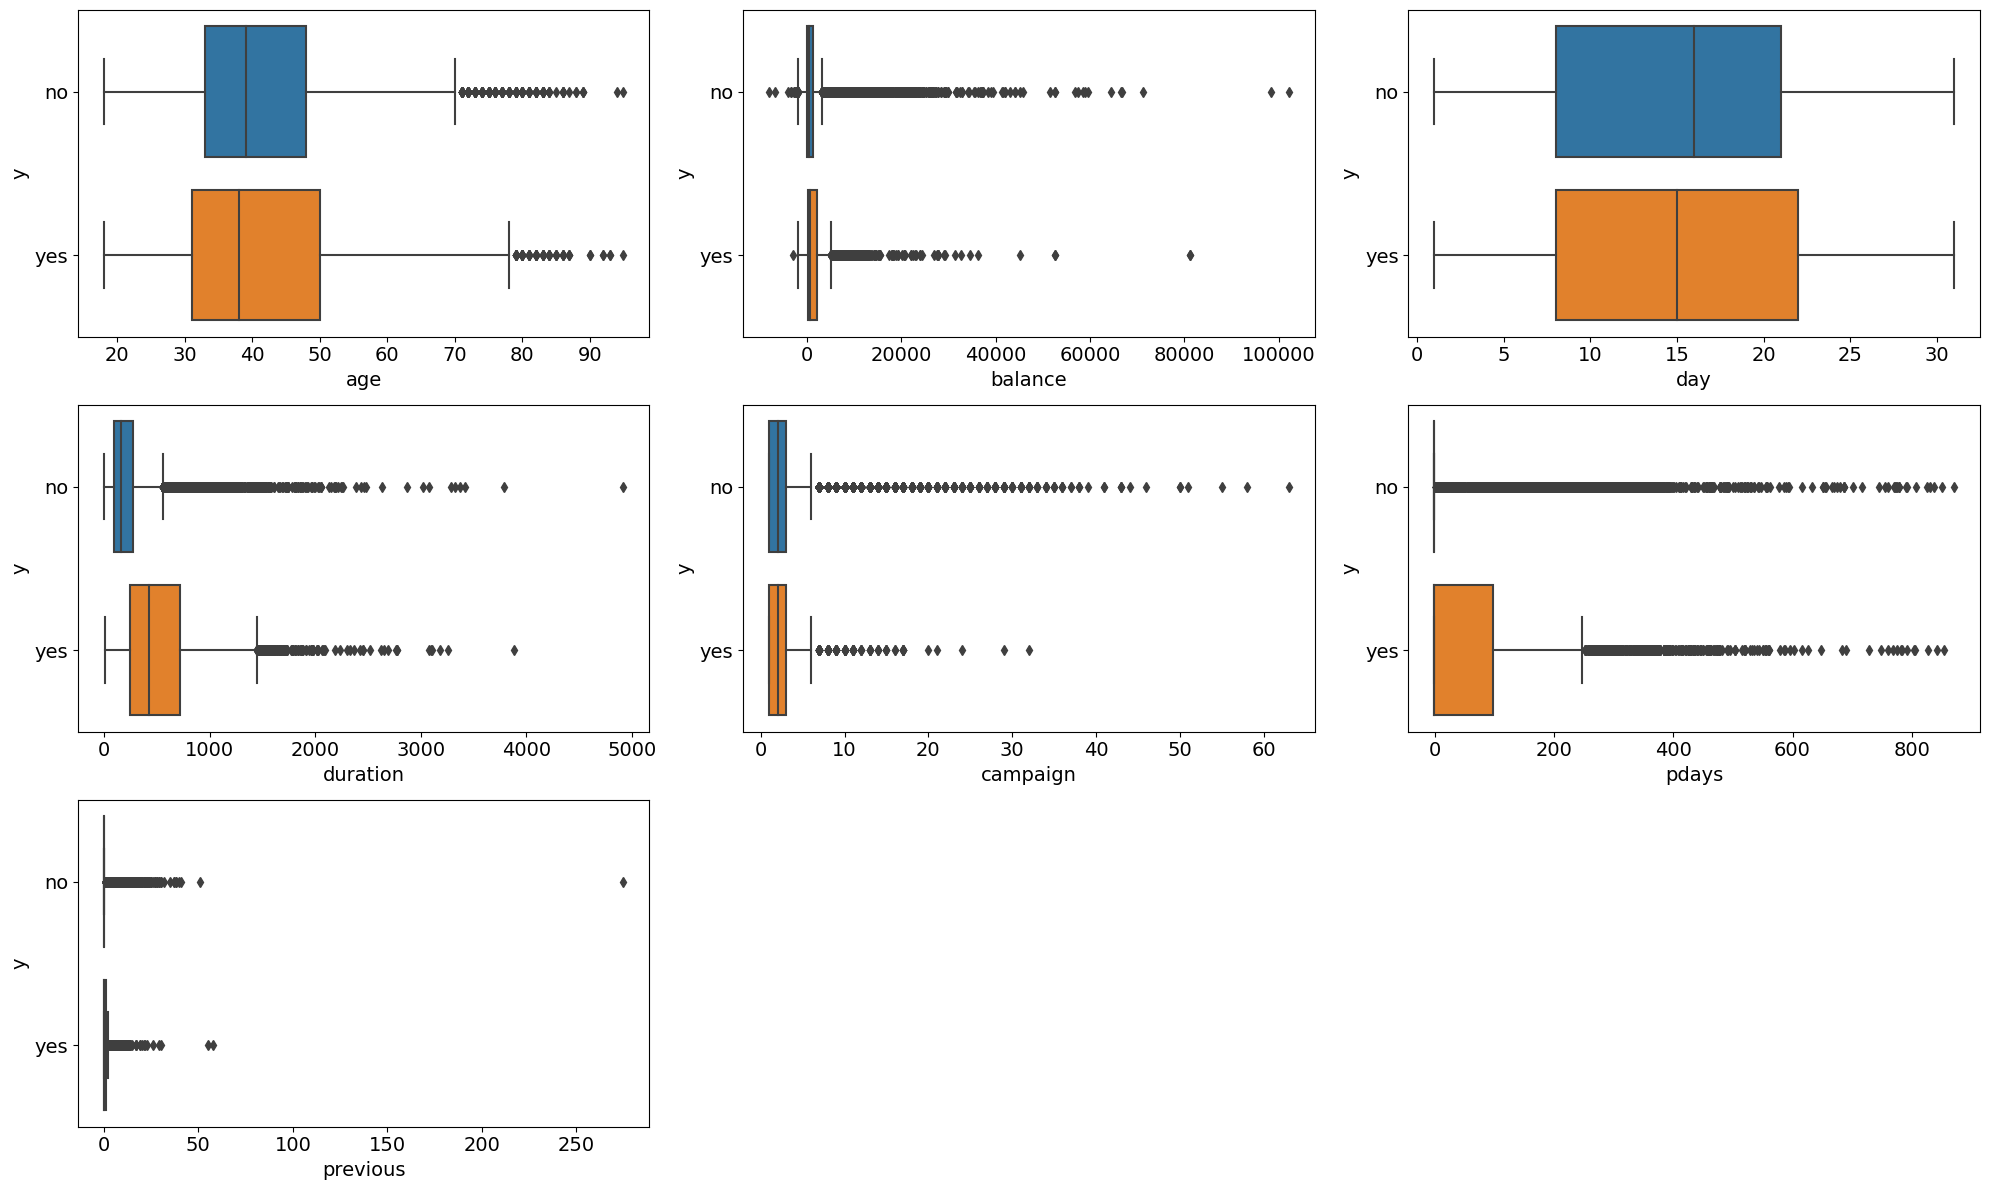

In [ ]:
plt.figure(figsize=(20, 12))
for i in range(len(num_cols)):
    plt.subplot(len(num_cols)//2, 3, i+1)
    ax = sns.boxplot(
        x = df[num_cols[i]],
        y = df["y"],
    )
    ax.set_xlabel(str(num_cols[i]), fontsize = 14)
    ax.set_ylabel("y", fontsize = 14)
    ax.tick_params(labelsize=14)
plt.tight_layout()

# Data Pre-Processing

## Things to Do
- Mengubah nilai -1 pada kolom `pdays` menjadi 999
- Normalisasi dan standardisasi data
- Handling outliers menggunakan Z-Score
- Handling imbalance menggunakan undersampling, oversampling, dan SMOTE

## Mengubah value -1 pada pdays

Kita akan mengubah nilai pdays=-1 menjadi 999 dengan mengasumsikan bahwa 999 hari merupakan waktu yang sangat lama

In [4]:
df['pdays'].replace({-1:999}, inplace = True)
df.sample(8)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
24587,35,self-employed,married,tertiary,no,560,yes,no,cellular,17,nov,46,1,999,0,unknown,no
31951,35,technician,married,secondary,no,327,yes,no,cellular,13,apr,537,3,999,0,unknown,no
31631,41,blue-collar,married,secondary,no,523,yes,no,cellular,6,apr,232,3,999,0,unknown,no
27008,45,admin.,divorced,secondary,no,2519,no,no,cellular,21,nov,470,1,999,0,unknown,no
35789,46,blue-collar,single,secondary,no,-100,yes,no,cellular,8,may,445,2,303,1,failure,no
25009,38,management,married,tertiary,no,595,yes,no,cellular,18,nov,70,1,999,0,unknown,no
37535,27,student,single,secondary,no,89,yes,no,cellular,14,may,68,3,999,0,unknown,no
2110,26,technician,single,secondary,no,124,yes,no,unknown,12,may,57,8,999,0,unknown,no


## Handling Outliers

In [5]:
# Split kolom numerikal dan kolom kategorikal
num_cols = df.select_dtypes('number').columns.tolist()
cat_cols = df.select_dtypes('object').columns.tolist()
print(num_cols)
print(cat_cols)

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


In [6]:
print(f'Jumlah baris sebelum memfilter outlier: {len(df)}')

filtered_entries = np.array([True] * len(df))

for col in num_cols: # nums = ['age','balance','day','duration','campaign','pdays','previous']
    zscore = abs(stats.zscore(df[col])) # hitung absolute z-scorenya
    filtered_entries = (zscore < 3) & filtered_entries # keep yang kurang dari 3 absolute z-scorenya
    
df = df[filtered_entries] # filter, cuma ambil yang z-scorenya dibawah 3

print(f'Jumlah baris setelah memfilter outlier: {len(df)}')

Jumlah baris sebelum memfilter outlier: 45211
Jumlah baris setelah memfilter outlier: 41794


## Normalization & Standardization

In [7]:
# Standardisasi kolom numerikal

std = ['age', 'day']

for i in num_cols:
  if (i in std) == True:
    df[str(i) + '_std'] = StandardScaler().fit_transform(df[str(i)].values.reshape(len(df), 1))
    df = df.drop(columns = str(i))
  else:
    df[str(i) + '_norm'] = MinMaxScaler().fit_transform(df[str(i)].values.reshape(len(df), 1))
    df = df.drop(columns = str(i))
  

df.sample(7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,job,marital,education,default,housing,loan,contact,month,poutcome,y,age_std,balance_norm,day_std,duration_norm,campaign_norm,pdays_norm,previous_norm
10602,blue-collar,single,secondary,no,yes,yes,unknown,jun,unknown,no,-0.455480,0.566013,0.035203,0.175728,0.090909,1.000000,0.000000
37224,blue-collar,married,primary,no,yes,no,cellular,may,failure,no,-0.554834,0.421350,-0.326497,0.556311,0.545455,0.326653,0.428571
32189,technician,single,tertiary,no,yes,no,cellular,apr,success,no,-0.654187,0.475476,-0.085364,0.524272,0.181818,0.270541,0.428571
27981,technician,married,secondary,no,no,no,cellular,jan,unknown,no,1.233522,0.473399,1.482001,0.141748,0.000000,1.000000,0.000000
25347,services,married,secondary,no,yes,no,cellular,nov,failure,no,-0.852893,0.616619,0.276336,0.097087,0.090909,0.188377,0.142857
32926,services,single,secondary,no,yes,yes,cellular,apr,failure,no,-0.952246,0.429890,0.155769,0.179612,0.090909,0.318637,0.285714
1857,blue-collar,single,secondary,no,yes,yes,unknown,may,unknown,no,-1.250305,0.395499,-0.808763,0.121359,0.181818,1.000000,0.000000


## Feature Encoding

Strategi encoding
* Label Encoding: `education`, `default`, `housing`, `loan`
* One Hot Encoding:  `job`, `marital`, `contact`, `poutcome`, `month`

In [8]:
# Label encoding

map_education={
    'primary' : 0,
    'secondary' : 1,
    'unknown' : 2,
    'tertiary' : 3
}

map = {
    'no' : 0,
    'yes' : 1
}


df['education'] = df['education'].map(map_education)

encoding = ['default', 'housing', 'loan', 'y']
for cols in encoding:
    df[cols] = df[cols].map(map)

df.sample(8)

,job,marital,education,default,housing,loan,contact,month,poutcome,y,age_std,balance_norm,day_std,duration_norm,campaign_norm,pdays_norm,previous_norm
21126,blue-collar,married,1,0,0,0,cellular,aug,unknown,0,0.836110,0.395095,-0.205930,0.183495,0.272727,1.000000,0.000000
23754,management,married,3,0,1,0,cellular,aug,unknown,0,-0.554834,0.492268,1.482001,0.037864,0.636364,1.000000,0.000000
36894,services,divorced,1,0,1,0,cellular,may,other,0,-0.058068,0.407155,-0.447063,0.293204,0.090909,0.343687,0.428571
40051,technician,married,1,0,1,1,cellular,jun,other,0,-0.654187,0.401673,-1.411595,0.148544,0.000000,0.308617,0.428571
18948,admin.,married,1,0,0,0,cellular,aug,unknown,0,0.538050,0.541258,-1.411595,0.273786,0.000000,1.000000,0.000000
25132,services,single,1,0,1,1,cellular,nov,failure,0,-0.852893,0.524986,0.276336,0.127184,0.000000,0.123246,0.142857
13022,technician,married,3,0,0,1,cellular,jul,unknown,0,0.935463,0.400404,-1.049896,0.186408,0.000000,1.000000,0.000000
43204,management,single,3,0,0,0,cellular,mar,other,1,-0.852893,0.415522,-1.411595,0.171845,0.090909,0.132265,0.714286


In [9]:
# One hot encoding
for cat in ['job', 'marital', 'contact', 'poutcome', 'month']:
    onehots = pd.get_dummies(df[cat], prefix=cat)
    df = df.join(onehots)

df.sample(7)

,job,marital,education,default,housing,loan,contact,month,poutcome,y,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
26210,entrepreneur,married,3,0,0,1,cellular,nov,unknown,0,...,0,0,0,0,0,0,0,1,0,0
41020,management,single,3,0,1,0,cellular,aug,success,1,...,0,0,0,0,0,0,0,0,0,0
42010,admin.,single,3,0,1,1,cellular,oct,success,0,...,0,0,0,0,0,0,0,0,1,0
14719,technician,single,3,0,0,0,telephone,jul,unknown,0,...,0,0,0,1,0,0,0,0,0,0
20259,technician,divorced,1,0,0,0,cellular,aug,unknown,0,...,0,0,0,0,0,0,0,0,0,0
3674,retired,divorced,0,0,0,0,unknown,may,unknown,0,...,0,0,0,0,0,0,1,0,0,0
21964,management,married,3,0,0,0,cellular,aug,unknown,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Drop columns
df = df.drop(columns = ['job', 'marital', 'contact', 'month', 'poutcome'])
df.sample(7)

,education,default,housing,loan,y,age_std,balance_norm,day_std,duration_norm,campaign_norm,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
27048,3,0,1,0,0,-0.455480,0.693480,0.638036,0.168932,0.000000,...,0,0,0,0,0,0,0,1,0,0
16856,3,0,0,0,0,0.140638,0.396249,1.120302,0.062136,0.090909,...,0,0,0,1,0,0,0,0,0,0
34830,1,0,1,0,0,-1.449011,0.395095,-1.170462,0.330097,0.000000,...,0,0,0,0,0,0,1,0,0,0
23155,3,0,0,0,0,-0.852893,0.417426,1.240868,0.096117,0.272727,...,0,0,0,0,0,0,0,0,0,0
16358,0,0,0,0,0,-0.852893,0.401039,0.879169,0.302913,0.000000,...,0,0,0,1,0,0,0,0,0,0
18614,1,0,0,0,0,0.339344,0.429602,1.843701,0.085437,0.363636,...,0,0,0,1,0,0,0,0,0,0
44110,1,0,0,0,1,-2.144483,0.416561,-0.929329,0.431068,0.181818,...,0,0,0,1,0,0,0,0,0,0


## Handling Class Imbalance

In [13]:
# Pemisahan features vs target
X = df.drop(columns=['y'])
y = df['y']
print(X.shape)
print(y.shape)

(41794, 45)
(41794,)


In [14]:
# Handling class imbalance

x_under, y_under = under_sampling.RandomUnderSampler(0.5, random_state=42).fit_resample(X, y)
x_over, y_over = over_sampling.RandomOverSampler(0.5, random_state=42).fit_resample(X, y)
x_smote, y_smote = over_sampling.SMOTE(0.5, random_state=42).fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:591: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,


In [15]:
print('Original')
print(pd.Series(y).value_counts())
print('UNDERSAMPLING')
print(pd.Series(y_under).value_counts())
print('OVERSAMPLING')
print(pd.Series(y_over).value_counts())
print('SMOTE')
print(pd.Series(y_smote).value_counts())

Original
0    37501
1     4293
Name: y, dtype: int64
UNDERSAMPLING
0    8586
1    4293
Name: y, dtype: int64
OVERSAMPLING
0    37501
1    18750
Name: y, dtype: int64
SMOTE
0    37501
1    18750
Name: y, dtype: int64


# Split Data Train & Test

In [16]:
# Split data train & test

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = 42)
xtrain_under, xtest_under, ytrain_under, ytest_under = train_test_split(x_under, y_under, test_size = 0.2, random_state = 42)
xtrain_over, xtest_over, ytrain_over, ytest_over = train_test_split(x_over, y_over, test_size = 0.2, random_state = 42)
xtrain_smote, xtest_smote, ytrain_smote, ytest_smote = train_test_split(x_smote, y_smote, test_size = 0.2, random_state = 42)

# Modeling

In [ ]:
df_eval = pd.DataFrame(columns=['model', 'dataset',  
                                'precision_train', 'precision', 
                                'auc_train', 'auc'])

classifiers = {
    "LogisticRegression": LogisticRegression(random_state=42),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(random_state=42, probability=True),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "Catboost": CatBoostClassifier(random_state = 42)
}

dataset = {
    'Original': [xtrain, ytrain, xtest, ytest],
    'Under Sampling': [xtrain_under, ytrain_under, xtest_under, ytest_under],
    'Over Sampling': [xtrain_over, ytrain_over, xtest_over, ytest_over],
    'SMOTE': [xtrain_smote, ytrain_smote, xtest_smote, ytest_smote]
}

for key in dataset:
  i = key
  x = dataset[i][0]
  y = dataset[i][1]
  x_test = dataset[i][2]
  y_test = dataset[i][3]
  
  for key in classifiers:
    j = key

    classifier = classifiers[j]
    model = classifier.fit(x, y)

    ypred = model.predict(x_test)
    ypred_train = model.predict(x)

    ypred_proba = model.predict_proba(x_test)
    ypred_train_proba = model.predict_proba(x)

    ypred_list = model.predict(x_test).tolist()

    row = {'model': j,
           'dataset': i,

           'precision_train': round(precision_score(y, ypred_train), 2),
           'precision': round(precision_score(y_test, ypred), 2),

           'auc_train': round(roc_auc_score(y, ypred_train_proba[:, 1]), 2),
           'auc': round(roc_auc_score(y_test, ypred_proba[:, 1]), 2),
           }

    df_eval = df_eval.append(row, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Learning rate set to 0.046107
0:	learn: 0.6328755	total: 88.1ms	remaining: 1m 27s
1:	learn: 0.5810400	total: 120ms	remaining: 59.7s
2:	learn: 0.5353021	total: 148ms	remaining: 49.1s
3:	learn: 0.5019649	total: 162ms	remaining: 40.3s
4:	learn: 0.4664508	total: 194ms	remaining: 38.6s
5:	learn: 0.4319296	total: 222ms	remaining: 36.8s
6:	learn: 0.4078315	total: 256ms	remaining: 36.3s
7:	learn: 0.3880964	total: 286ms	remaining: 35.5s
8:	learn: 0.3681273	total: 322ms	remaining: 35.5s
9:	learn: 0.3537573	total: 351ms	remaining: 34.7s
10:	learn: 0.3400713	total: 390ms	remaining: 35.1s
11:	learn: 0.3275997	total: 421ms	remaining: 34.7s
12:	learn: 0.3153777	total: 461ms	remaining: 35s
13:	learn: 0.3053978	total: 507ms	remaining: 35.7s
14:	learn: 0.2958184	total: 540ms	remaining: 35.5s
15:	learn: 0.2891140	total: 572ms	remaining: 35.2s
16:	learn: 0.2822062	total: 628ms	remaining: 36.3s
17:	learn: 0.2763227	total: 675ms	remaining: 36.8s
18:	learn: 0.2703357	total: 699ms	remaining: 36.1s
19:	learn: 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Learning rate set to 0.027891
0:	learn: 0.6769871	total: 34.8ms	remaining: 34.8s
1:	learn: 0.6584874	total: 60.2ms	remaining: 30.1s
2:	learn: 0.6415459	total: 85.2ms	remaining: 28.3s
3:	learn: 0.6300571	total: 111ms	remaining: 27.6s
4:	learn: 0.6150795	total: 140ms	remaining: 27.8s
5:	learn: 0.6023750	total: 162ms	remaining: 26.8s
6:	learn: 0.5911782	total: 204ms	remaining: 29s
7:	learn: 0.5794846	total: 228ms	remaining: 28.3s
8:	learn: 0.5684701	total: 262ms	remaining: 28.8s
9:	learn: 0.5602153	total: 287ms	remaining: 28.4s
10:	learn: 0.5507546	total: 306ms	remaining: 27.5s
11:	learn: 0.5408321	total: 343ms	remaining: 28.2s
12:	learn: 0.5324792	total: 366ms	remaining: 27.8s
13:	learn: 0.5242340	total: 394ms	remaining: 27.8s
14:	learn: 0.5163828	total: 416ms	remaining: 27.3s
15:	learn: 0.5104279	total: 441ms	remaining: 27.1s
16:	learn: 0.5035906	total: 465ms	remaining: 26.9s
17:	learn: 0.4980516	total: 493ms	remaining: 26.9s
18:	learn: 0.4919780	total: 528ms	remaining: 27.3s
19:	learn:

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Learning rate set to 0.052343
0:	learn: 0.6569127	total: 16.7ms	remaining: 16.6s
1:	learn: 0.6239123	total: 32.2ms	remaining: 16.1s
2:	learn: 0.5975956	total: 45.2ms	remaining: 15s
3:	learn: 0.5758828	total: 58.5ms	remaining: 14.6s
4:	learn: 0.5537336	total: 71.3ms	remaining: 14.2s
5:	learn: 0.5342648	total: 84.1ms	remaining: 13.9s
6:	learn: 0.5178004	total: 97.2ms	remaining: 13.8s
7:	learn: 0.5066526	total: 110ms	remaining: 13.7s
8:	learn: 0.4935517	total: 124ms	remaining: 13.6s
9:	learn: 0.4828455	total: 136ms	remaining: 13.5s
10:	learn: 0.4723882	total: 149ms	remaining: 13.4s
11:	learn: 0.4650173	total: 162ms	remaining: 13.3s
12:	learn: 0.4572449	total: 175ms	remaining: 13.3s
13:	learn: 0.4506103	total: 189ms	remaining: 13.3s
14:	learn: 0.4451185	total: 209ms	remaining: 13.7s
15:	learn: 0.4390672	total: 222ms	remaining: 13.6s
16:	learn: 0.4320648	total: 235ms	remaining: 13.6s
17:	learn: 0.4263910	total: 248ms	remaining: 13.5s
18:	learn: 0.4212068	total: 263ms	remaining: 13.6s
19:	le

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Learning rate set to 0.052343
0:	learn: 0.6498281	total: 51ms	remaining: 51s
1:	learn: 0.6123344	total: 93.3ms	remaining: 46.5s
2:	learn: 0.5829558	total: 139ms	remaining: 46.1s
3:	learn: 0.5479698	total: 186ms	remaining: 46.3s
4:	learn: 0.5248717	total: 211ms	remaining: 42s
5:	learn: 0.5004776	total: 244ms	remaining: 40.4s
6:	learn: 0.4818830	total: 269ms	remaining: 38.2s
7:	learn: 0.4643711	total: 297ms	remaining: 36.8s
8:	learn: 0.4436456	total: 340ms	remaining: 37.5s
9:	learn: 0.4346121	total: 390ms	remaining: 38.6s
10:	learn: 0.4232899	total: 440ms	remaining: 39.6s
11:	learn: 0.4138733	total: 489ms	remaining: 40.3s
12:	learn: 0.3946306	total: 535ms	remaining: 40.6s
13:	learn: 0.3871369	total: 581ms	remaining: 41s
14:	learn: 0.3794474	total: 634ms	remaining: 41.6s
15:	learn: 0.3737477	total: 673ms	remaining: 41.4s
16:	learn: 0.3691317	total: 691ms	remaining: 40s
17:	learn: 0.3640772	total: 709ms	remaining: 38.7s
18:	learn: 0.3598417	total: 729ms	remaining: 37.7s
19:	learn: 0.351563

In [ ]:
df_eval[df_eval.dataset == 'Original']

,model,dataset,precision_train,precision,auc_train,auc
0,LogisticRegression,Original,0.64,0.64,0.91,0.91
1,KNN,Original,0.75,0.54,0.95,0.74
2,DecisionTree,Original,1.00,0.46,1.00,0.70
3,SVM,Original,0.75,0.67,0.94,0.91
4,RandomForest,Original,1.00,0.64,1.00,0.93
5,GradientBoosting,Original,0.72,0.66,0.93,0.92
6,AdaBoost,Original,0.63,0.61,0.91,0.91
7,XGBoost,Original,0.73,0.68,0.93,0.92
8,Catboost,Original,0.87,0.65,0.97,0.94


In [ ]:
df_eval[df_eval.dataset == 'Under Sampling']

,model,dataset,precision_train,precision,auc_train,auc
9,LogisticRegression,Under Sampling,0.79,0.80,0.91,0.92
10,KNN,Under Sampling,0.85,0.75,0.92,0.79
11,DecisionTree,Under Sampling,1.00,0.72,1.00,0.78
12,SVM,Under Sampling,0.82,0.79,0.94,0.93
13,RandomForest,Under Sampling,1.00,0.79,1.00,0.93
14,GradientBoosting,Under Sampling,0.81,0.80,0.94,0.93
15,AdaBoost,Under Sampling,0.79,0.81,0.91,0.92
16,XGBoost,Under Sampling,0.80,0.80,0.93,0.93
17,Catboost,Under Sampling,0.89,0.81,0.98,0.94


In [ ]:
df_eval[df_eval.dataset == 'Over Sampling']

,model,dataset,precision_train,precision,auc_train,auc
18,LogisticRegression,Over Sampling,0.78,0.79,0.91,0.91
19,KNN,Over Sampling,0.84,0.78,0.98,0.94
20,DecisionTree,Over Sampling,1.00,0.88,1.00,0.96
21,SVM,Over Sampling,0.81,0.81,0.95,0.94
22,RandomForest,Over Sampling,1.00,0.92,1.00,1.00
23,GradientBoosting,Over Sampling,0.80,0.80,0.93,0.93
24,AdaBoost,Over Sampling,0.79,0.79,0.91,0.91
25,XGBoost,Over Sampling,0.79,0.79,0.93,0.93
26,Catboost,Over Sampling,0.89,0.85,0.98,0.97


In [ ]:
df_eval[df_eval.dataset == 'SMOTE']

,model,dataset,precision_train,precision,auc_train,auc
27,LogisticRegression,SMOTE,0.87,0.87,0.96,0.96
28,KNN,SMOTE,0.86,0.81,0.98,0.95
29,DecisionTree,SMOTE,1.00,0.82,1.00,0.87
30,SVM,SMOTE,0.88,0.87,0.97,0.97
31,RandomForest,SMOTE,1.00,0.89,1.00,0.99
32,GradientBoosting,SMOTE,0.86,0.86,0.97,0.96
33,AdaBoost,SMOTE,0.85,0.85,0.95,0.95
34,XGBoost,SMOTE,0.86,0.85,0.97,0.96
35,Catboost,SMOTE,0.96,0.92,0.99,0.99


In [ ]:
df_eval.sort_values('auc', ascending = False).head(5)

,model,dataset,precision_train,precision,auc_train,auc
22,RandomForest,Over Sampling,1.00,0.92,1.00,1.00
35,Catboost,SMOTE,0.96,0.92,0.99,0.99
31,RandomForest,SMOTE,1.00,0.89,1.00,0.99
30,SVM,SMOTE,0.88,0.87,0.97,0.97
26,Catboost,Over Sampling,0.89,0.85,0.98,0.97


In [ ]:
df_eval.sort_values('precision', ascending = False).head(5)

,model,dataset,precision_train,precision,auc_train,auc
35,Catboost,SMOTE,0.96,0.92,0.99,0.99
22,RandomForest,Over Sampling,1.00,0.92,1.00,1.00
31,RandomForest,SMOTE,1.00,0.89,1.00,0.99
20,DecisionTree,Over Sampling,1.00,0.88,1.00,0.96
27,LogisticRegression,SMOTE,0.87,0.87,0.96,0.96


# Best Model
Model Terbaik: Random Forest Oversampling

## Before Hyperparameter Tuning

In [30]:
# Definition eval_classification

def eval_classification(model, x_train, y_train, x_test, y_test):
  ypred = model.predict(x_test)
  ypred_train = model.predict(x_train)
  ypred_proba = model.predict_proba(x_test)
  ypred_train_proba = model.predict_proba(x_train)

  print("Precision (Train Set): %.3f" % precision_score(y_train, ypred_train))
  print("Precision (Test Set): %.3f" % precision_score(y_test, ypred))
  print('')
  print("AUC (Train Set): %.3f" % roc_auc_score(y_train, ypred_train_proba[:, 1]))
  print("AUC (Test Set): %.3f" % roc_auc_score(y_test, ypred_proba[:, 1]))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [28]:
xtrain_over, xtest_over, ytrain_over, ytest_over = train_test_split(x_over, y_over, test_size=0.2, random_state=50)

rf = RandomForestClassifier(random_state=50)
rf.fit(xtrain_over, ytrain_over)
eval_classification(rf, xtrain_over, ytrain_over, xtest_over, ytest_over)

Precision (Train Set): 1.000
Precision (Test Set): 0.925

AUC (Train Set): 1.000
AUC (Test Set): 0.998


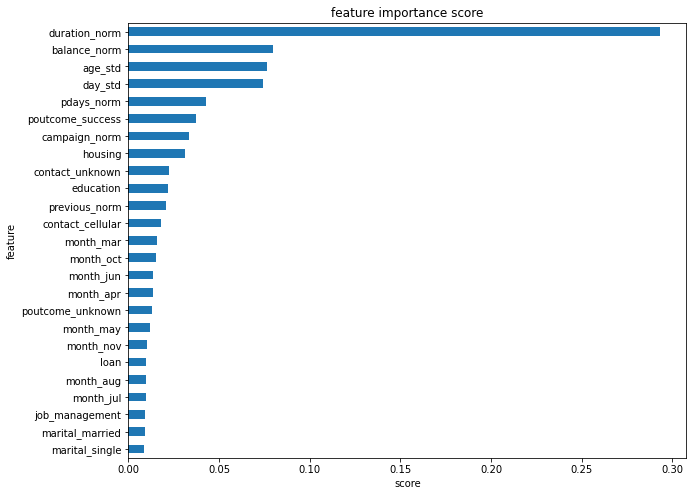

In [31]:
# Feature Importance
show_feature_importance(rf)

In [33]:
fi = rf.feature_importances_

df_fi = pd.DataFrame(data = fi, index = X.columns, columns = ['score'])
df_fi = df_fi.reset_index()
df_fi.sort_values('score', ascending = False)

,index,score
7,duration_norm,0.293057
5,balance_norm,0.079973
4,age_std,0.076342
6,day_std,0.074145
9,pdays_norm,0.042563
31,poutcome_success,0.037319
8,campaign_norm,0.033332
2,housing,0.031131
28,contact_unknown,0.022410
0,education,0.021704


In [34]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(xtest_over)
print('Confusion Matrix:')
print(confusion_matrix(ytest_over, y_pred))

Confusion Matrix:
[[7198  302]
 [  45 3706]]


In [35]:
# Classification Report
print('Classification Report:')
print(classification_report(ytest_over, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      7500
           1       0.92      0.99      0.96      3751

    accuracy                           0.97     11251
   macro avg       0.96      0.97      0.97     11251
weighted avg       0.97      0.97      0.97     11251



## Hyperparameter Tuning

In [ ]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 50,
 'verbose': 0,
 'warm_start': False}


In [ ]:
# Hyperparameter Tuning
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(100, 1000, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100,
                  200,
                  300,
                  400,
                  500,
                  600,
                  700,
                  800,
                  900,
                  1000,
                  1100,
                  1200,
                  1300,
                  1400,
                  1500,
                  1600,
                  1700,
                  1800,
                  1900,
                  2000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=50, n_jobs = -1)

# Fit the random search model
rf_random.fit(xtrain_over, ytrain_over)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [100, 200, 300, 400, 500,
                                                      600, 700, 800, 900, 1000,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100, 1200,
                                                         1300, 1400, 1500, 1600,
                                                         1700, 1800, 1900,
 

In [ ]:
rf_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 600,
 'bootstrap': False}

In [ ]:
def evaluate(model):
    y_pred = model.predict(xtest_over)
    y_pred_train = model.predict(xtrain_over)
    y_pred_proba = model.predict_proba(xtest_over)
    y_pred_proba_train = model.predict_proba(xtrain_over)
    print('Model Performance')
    print('')
    print("Precision (Train Set): %.3f" % precision_score(ytrain_over, y_pred_train))
    print("Precision (Test Set): %.3f" % precision_score(ytest_over, y_pred))

    print("AUC (train-proba): %.3f" % roc_auc_score(ytrain_over, y_pred_proba_train[:, 1]))
    print("AUC (test-proba): %.3f" % roc_auc_score(ytest_over, y_pred_proba[:, 1]))

base_model = RandomForestClassifier(n_estimators = 100, random_state = 50)
base_model.fit(xtest_over, ytrain_over)
base_accuracy = evaluate(rf)

Model Performance
Precision (Train Set): 1.000
Precision (Test Set): 0.929
AUC (train-proba): 1.000
AUC (test-proba): 0.998


In [ ]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random)

Model Performance
Precision (Train Set): 1.000
Precision (Test Set): 0.953
AUC (train-proba): 1.000
AUC (test-proba): 0.998


In [ ]:
pprint(best_random.get_params())

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 600,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [ ]:
par = {'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 600,
 'bootstrap': False}

precisions = []
ROC_AUCs = []
for i in range(10):
    model = RandomForestClassifier(**par)
    setattr(model, 'random_state', i)
    model.fit(xtrain_over, ytrain_over)
    y_pred = model.predict(xtest_over)
    precisions.append(precision_score(ytest_over, y_pred))
    ROC_AUCs.append(roc_auc_score(ytest_over, y_pred))
    
precArr = np.array(precisions)
rocArr = np.array(ROC_AUCs)
print(f'max precision = {precArr.max()}, rs = {precArr.argmax()}')
print(f'max ROC_AUC = {rocArr.max()}, rs = {rocArr.argmax()}')

max precision = 0.9543923296190723, rs = 3
max ROC_AUC = 0.9797355727361592, rs = 1


In [17]:
xtrain_over, xtest_over, ytrain_over, ytest_over = train_test_split(x_over, y_over, test_size=0.2, random_state=50)

par = {'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 600,
 'bootstrap': False, 'random_state':200}

rf = RandomForestClassifier(**par)
rf.fit(xtrain_over, ytrain_over)
y_pred = rf.predict(xtest_over)
y_pred_train = rf.predict(xtrain_over)
y_pred_proba = rf.predict_proba(xtest_over)
y_pred_proba_train = rf.predict_proba(xtrain_over)
  
print("Precision (Train Set): %.5f" % precision_score(ytrain_over, y_pred_train))
print("Precision (Test Set): %.5f" % precision_score(ytest_over, y_pred))
print("AUC (train-proba): %.5f" % roc_auc_score(ytrain_over, y_pred_proba_train[:, 1]))
print("AUC (test-proba): %.5f" % roc_auc_score(ytest_over, y_pred_proba[:, 1]))

Precision (Train Set): 1.00000
Precision (Test Set): 0.95281
AUC (train-proba): 1.00000
AUC (test-proba): 0.99828


In [22]:
# Improvement = Precision Test After Param - Precision Test Before Param
print('Improvement of {:0.2f}%.'. format((0.953-0.925)*100))

Improvement of 2.80%.


In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report

print('Confusion Matrix:')
print(confusion_matrix(ytest_over, y_pred))

Confusion Matrix:
[[7326  174]
 [  56 3695]]


In [ ]:
# Classification Report
print('Classification Report:')
print(classification_report(ytest_over, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7500
           1       0.96      0.99      0.97      3751

    accuracy                           0.98     11251
   macro avg       0.97      0.98      0.98     11251
weighted avg       0.98      0.98      0.98     11251



##  Feature Importance

In [18]:
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

In [19]:
fi = rf.feature_importances_

df_fi = pd.DataFrame(data = fi, index = X.columns, columns = ['score'])
df_fi = df_fi.reset_index()
df_fi.sort_values('score', ascending = False)

,index,score
7,duration_norm,0.294923
5,balance_norm,0.080958
4,age_std,0.076202
6,day_std,0.074164
31,poutcome_success,0.042345
9,pdays_norm,0.041421
8,campaign_norm,0.033086
2,housing,0.030588
28,contact_unknown,0.021769
0,education,0.021138


### Correlation

In [20]:
corr_list = []

for i in df_fi['index'].tolist():
  for j in df_fi['index'].tolist():
    if i != j:
      corr_sort = sorted([i, j])
      if corr_sort not in corr_list:
        corr_list.append(corr_sort)
        corr_list.sort()

corr_list

[['age_std', 'balance_norm'],
 ['age_std', 'campaign_norm'],
 ['age_std', 'contact_cellular'],
 ['age_std', 'contact_telephone'],
 ['age_std', 'contact_unknown'],
 ['age_std', 'day_std'],
 ['age_std', 'default'],
 ['age_std', 'duration_norm'],
 ['age_std', 'education'],
 ['age_std', 'housing'],
 ['age_std', 'job_admin.'],
 ['age_std', 'job_blue-collar'],
 ['age_std', 'job_entrepreneur'],
 ['age_std', 'job_housemaid'],
 ['age_std', 'job_management'],
 ['age_std', 'job_retired'],
 ['age_std', 'job_self-employed'],
 ['age_std', 'job_services'],
 ['age_std', 'job_student'],
 ['age_std', 'job_technician'],
 ['age_std', 'job_unemployed'],
 ['age_std', 'job_unknown'],
 ['age_std', 'loan'],
 ['age_std', 'marital_divorced'],
 ['age_std', 'marital_married'],
 ['age_std', 'marital_single'],
 ['age_std', 'month_apr'],
 ['age_std', 'month_aug'],
 ['age_std', 'month_dec'],
 ['age_std', 'month_feb'],
 ['age_std', 'month_jan'],
 ['age_std', 'month_jul'],
 ['age_std', 'month_jun'],
 ['age_std', 'month_

In [21]:
from scipy.stats import pearsonr

for i in range(len(corr_list)):
  corr, _ = pearsonr(df[(corr_list[i][0])], df[corr_list[i][1]])
  if corr > 0.8 or corr < -0.8:
    print(f'Correlation {corr_list[i][0]} & {corr_list[i][1]}: %.3f' % corr)
    print('')

Correlation contact_cellular & contact_unknown: -0.874

Correlation pdays_norm & poutcome_unknown: 0.986

Correlation pdays_norm & previous_norm: -0.812

Correlation poutcome_unknown & previous_norm: -0.814



##  Feature Selection

In [20]:
xtrain_over, xtest_over, ytrain_over, ytest_over = train_test_split(x_over, y_over, test_size=0.2, random_state=50)
to_drop = ['poutcome_unknown','contact_cellular']

X_train_selection = xtrain_over.drop(to_drop, axis=1)
X_test_selection = xtest_over.drop(to_drop, axis=1)

In [21]:
par = {'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 600,
 'bootstrap': False, 'random_state':200}

rf = RandomForestClassifier(**par)
rf.fit(X_train_selection, ytrain_over)
y_pred = rf.predict(X_test_selection)
y_pred_train = rf.predict(X_train_selection)
y_pred_proba = rf.predict_proba(X_test_selection)
y_pred_proba_train = rf.predict_proba(X_train_selection)
  
print("Precision (Train Set): %.5f" % precision_score(ytrain_over, y_pred_train))
print("Precision (Test Set): %.5f" % precision_score(ytest_over, y_pred))
print("AUC (train-proba): %.5f" % roc_auc_score(ytrain_over, y_pred_proba_train[:, 1]))
print("AUC (test-proba): %.5f" % roc_auc_score(ytest_over, y_pred_proba[:, 1]))

Precision (Train Set): 1.00000
Precision (Test Set): 0.95382
AUC (train-proba): 1.00000
AUC (test-proba): 0.99838


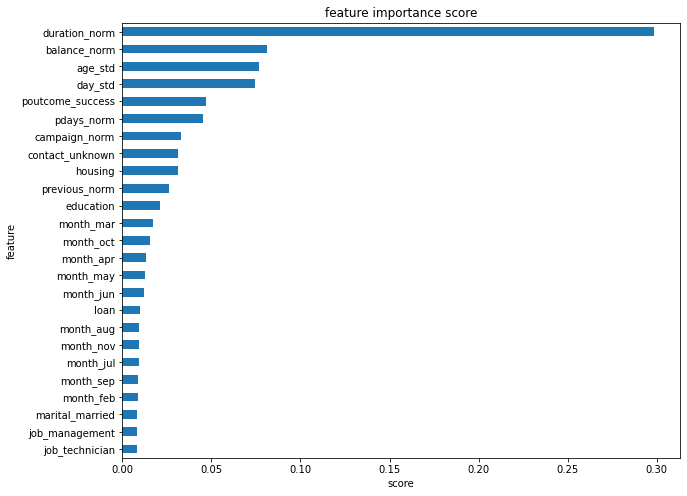

In [24]:
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X_train_selection.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

show_feature_importance(rf)

In [26]:
fi = rf.feature_importances_

df_fi = pd.DataFrame(data = fi, index = X_train_selection.columns, columns = ['score'])
df_fi = df_fi.reset_index()
df_fi.sort_values('score', ascending = False)

,index,score
7,duration_norm,0.298190
5,balance_norm,0.081089
4,age_std,0.076488
6,day_std,0.074336
30,poutcome_success,0.046976
9,pdays_norm,0.045298
8,campaign_norm,0.032793
27,contact_unknown,0.031165
2,housing,0.031039
10,previous_norm,0.026260


In [28]:
# Improvement = Precision Test After Param - Precision Test Before Param
print('Improvement of {:0.2f}%.'. format((0.954-0.925)*100))

Improvement of 2.90%.


In [29]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report

print('Confusion Matrix:')
print(confusion_matrix(ytest_over, y_pred))

Confusion Matrix:
[[7321  179]
 [  54 3697]]


In [30]:
# Classification Report
print('Classification Report:')
print(classification_report(ytest_over, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7500
           1       0.95      0.99      0.97      3751

    accuracy                           0.98     11251
   macro avg       0.97      0.98      0.98     11251
weighted avg       0.98      0.98      0.98     11251

